In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process_example import *

df = pd.read_csv('gp_objects.csv')
display(df)
obj = sorted(df.obj_id.unique())

mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
0      58226.340532  142.373588   98.668109        30.843697         1.246373   
1      58226.390513  145.014457  101.582057        30.013242         1.080243   
2      58226.440494  147.656847  104.490322        29.187955         1.080575   
3      58226.490474  150.300692  107.379974        28.367979         1.219787   
4      58226.540455  152.945927  110.245034        27.553467         1.433721   
...             ...         ...         ...              ...              ...   
72996  60652.513689   33.493383   40.961798         3.488673         5.252959   
72997  60652.519801   33.463261   40.930338         3.842217         5.054402   
72998  60652.525913   33.432509   40.895906         4.235472         4.909244   
72999  60652.532025   33.401076   40.858402         4.657035         4.823773   
73000  60652.538137   33.368917   40.817727         5.098662         4.802653   

      type        obj_id         mjd_0  redshift  flux_ztfi  ...   mag_ztfg  \
0      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN  ...  18.516426   
1      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN  ...  18.496472   
2      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN  ...  18.476866   
3      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN  ...  18.457598   
4      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN  ...  18.438655   
...    ...           ...           ...       ...        ...  ...        ...   
72996  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN  ...  20.087602   
72997  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN  ...  20.088579   
72998  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN  ...  20.089578   
72999  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN  ...  20.090599   
73000  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN  ...  20.091645   

       abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  mag_error_ztfr  \
0        -13.834339        0.235213  18.914558    -13.436208        0.013715   
1        -13.854294        0.224712  18.882957    -13.467808        0.011546   
2        -13.873900        0.214622  18.852310    -13.498456        0.011228   
3        -13.893168        0.204923  18.822692    -13.528074        0.012333   
4        -13.912110        0.195597  18.794102    -13.556663        0.014120   
...             ...             ...        ...           ...             ...   
72996    -10.921953        0.113090  19.869052    -11.140503        0.139235   
72997    -10.920976        0.124663  19.869887    -11.139669        0.134075   
72998    -10.919978        0.137549  19.870800    -11.138755        0.130334   
72999    -10.918957        0.151382  19.871797    -11.137759        0.128183   
73000    -10.917911        0.165897  19.872878    -11.136678        0.127749   

       mag_ztfi  abs_mag_ztfi  mag_error_ztfi         t  
0           NaN           NaN             NaN  0.000000  
1           NaN           NaN             NaN  0.049981  
2           NaN           NaN             NaN  0.099961  
3           NaN           NaN             NaN  0.149942  
4           NaN           NaN             NaN  0.199923  
...         ...           ...             ...       ...  
72996       NaN           NaN             NaN  6.081386  
72997       NaN           NaN             NaN  6.087498  
72998       NaN           NaN             NaN  6.093610  
72999       NaN           NaN             NaN  6.099721  
73000       NaN           NaN             NaN  6.105833  

[73001 rows x 21 columns]

In [6]:
color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Flux') 
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)

    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd' and 'abs' not in column:
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['t'], obj_model[column], label=f'Model {filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['t'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)

    return f,ax

In [7]:
def cut_data(df, obj_id, cutoff, plot=True):
    obj_model = df[df['obj_id'] == obj_id]
    if plot:
        f, ax = plot_gp(obj_model)
        ax.axvline(cutoff, color='black', linestyle='--', label='Cutoff')
        plt.show()

    obj_model = obj_model[obj_model['t'] < cutoff]
    combined_df = pd.concat([df[df['obj_id'] != obj_id], obj_model])
    return combined_df

In [8]:
obj[27]

'ZTF20acozryr'

In [9]:
df[df['obj_id'] == obj[30]]

mjd  flux_ztfg  flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
30000  59215.423935  85.374642  48.127260        13.369288        16.339748   
30001  59215.473862  85.090440  47.967696        13.292463        16.169958   
30002  59215.523788  84.803178  47.809294        13.218421        16.000350   
30003  59215.573715  84.512958  47.652101        13.147104        15.830930   
30004  59215.623641  84.219887  47.496163        13.078451        15.661702   
...             ...        ...        ...              ...              ...   
30995  59265.100815  24.329480  72.392327        10.606644         2.348583   
30996  59265.150741  24.272965  72.168410        10.783509         2.409474   
30997  59265.200668  24.216345  71.944592        10.960475         2.476394   
30998  59265.250594  24.159620  71.721024        11.137531         2.549509   
30999  59265.300521  24.102787  71.497819        11.314670         2.628919   

      type        obj_id         mjd_0  redshift  flux_ztfi  ...   mag_ztfg  \
30000  IIb  ZTF21aaabrpu  59215.423935  0.027172  37.895474  ...  19.071678   
30001  IIb  ZTF21aaabrpu  59215.423935  0.027172  37.940301  ...  19.075298   
30002  IIb  ZTF21aaabrpu  59215.423935  0.027172  37.987126  ...  19.078970   
30003  IIb  ZTF21aaabrpu  59215.423935  0.027172  38.035970  ...  19.082692   
30004  IIb  ZTF21aaabrpu  59215.423935  0.027172  38.086852  ...  19.086463   
...    ...           ...           ...       ...        ...  ...        ...   
30995  IIb  ZTF21aaabrpu  59215.423935  0.027172  86.230208  ...  20.434668   
30996  IIb  ZTF21aaabrpu  59215.423935  0.027172  86.059716  ...  20.437193   
30997  IIb  ZTF21aaabrpu  59215.423935  0.027172  85.888701  ...  20.439729   
30998  IIb  ZTF21aaabrpu  59215.423935  0.027172  85.717168  ...  20.442275   
30999  IIb  ZTF21aaabrpu  59215.423935  0.027172  85.545123  ...  20.444832   

       abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  mag_error_ztfr  \
30000    -11.375703        0.170021  19.694022    -10.753358        0.368620   
30001    -11.372082        0.169609  19.697628    -10.749753        0.366003   
30002    -11.368411        0.169236  19.701219    -10.746161        0.363364   
30003    -11.364689        0.168901  19.704795    -10.742586        0.360702   
30004    -11.360917        0.168603  19.708354    -10.739027        0.358018   
...             ...             ...        ...           ...             ...   
30995    -10.012713        0.473336  19.250769    -11.196612        0.035224   
30996    -10.010188        0.482349  19.254132    -11.193248        0.036249   
30997    -10.007652        0.491411  19.257505    -11.189876        0.037372   
30998    -10.005106        0.500522  19.260884    -11.186497        0.038595   
30999    -10.002549        0.509682  19.264268    -11.183112        0.039922   

        mag_ztfi  abs_mag_ztfi  mag_error_ztfi          t  
30000  19.953532    -10.493849        0.746163   0.000000  
30001  19.952248    -10.495132        0.740427   0.049927  
30002  19.950909    -10.496472        0.734669   0.099853  
30003  19.949514    -10.497867        0.728888   0.149780  
30004  19.948062    -10.499318        0.723086   0.199706  
...          ...           ...             ...        ...  
30995  19.060851    -11.386529        0.138250  49.676880  
30996  19.063000    -11.384380        0.140258  49.726806  
30997  19.065160    -11.382221        0.142289  49.776733  
30998  19.067330    -11.380050        0.144343  49.826659  
30999  19.069512    -11.377869        0.146419  49.876586  

[1000 rows x 21 columns]

In [10]:
df[df['obj_id'] == obj[7]].describe()

mjd    flux_ztfg    flux_ztfr  flux_error_ztfg  \
count   1000.000000  1000.000000  1000.000000      1000.000000   
mean   58627.280185   142.121326   861.140222        93.304214   
std       14.452797   188.787985   487.584910        84.223140   
min    58602.284734  -666.695160   254.377882         5.212970   
25%    58614.782460    63.476039   382.289806        30.068834   
50%    58627.280185    92.320061   703.088975        61.465941   
75%    58639.777911   283.835266  1317.531775       134.262929   
max    58652.275637   443.856591  1804.176852       351.800805   

       flux_error_ztfr         mjd_0      redshift    flux_ztfi  \
count      1000.000000   1000.000000  1.000000e+03  1000.000000   
mean         64.641135  58602.284734  4.300000e-03  1541.853930   
std          44.252403      0.000000  8.677957e-19   630.046807   
min          12.327590  58602.284734  4.300000e-03   773.069255   
25%          28.774022  58602.284734  4.300000e-03   937.594671   
50%          52.628801  58602.284734  4.300000e-03  1386.897054   
75%          93.525527  58602.284734  4.300000e-03  2129.386670   
max         175.337949  58602.284734  4.300000e-03  2632.631664   

       flux_error_ztfi    mag_ztfg  abs_mag_ztfg  mag_error_ztfg     mag_ztfr  \
count      1000.000000  926.000000    926.000000     1000.000000  1000.000000   
mean        240.502708   18.704473     -7.702448        1.998750    16.756797   
std         136.779736    1.097280      1.097280       91.193779     0.669439   
min          20.389203   17.281893     -9.125028    -1274.706974    15.759302   
25%         113.195269   17.714430     -8.692491        0.121950    16.100597   
50%         250.856424   18.942437     -7.464484        0.351393    16.782476   
75%         381.414597   19.346926     -7.059995        0.830791    17.444019   
max         415.609404   25.999469     -0.407452     2289.444073    17.886302   

       abs_mag_ztfr  mag_error_ztfr     mag_ztfi  abs_mag_ztfi  \
count   1000.000000     1000.000000  1000.000000   1000.000000   
mean      -9.650124        0.086787    16.022959    -10.383962   
std        0.669439        0.044070     0.452460      0.452460   
min      -10.647619        0.027833    15.349025    -11.057896   
25%      -10.306324        0.047508    15.579364    -10.827557   
50%       -9.624445        0.077492    16.044891    -10.362030   
75%       -8.962902        0.116183    16.469962     -9.936959   
max       -8.520619        0.182777    16.679454     -9.727467   

       mag_error_ztfi            t  
count     1000.000000  1000.000000  
mean         0.174655    24.995451  
std          0.091729    14.452797  
min          0.022855     0.000000  
25%          0.088172    12.497726  
50%          0.183508    24.995451  
75%          0.248737    37.493177  
max          0.320627    49.990903

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


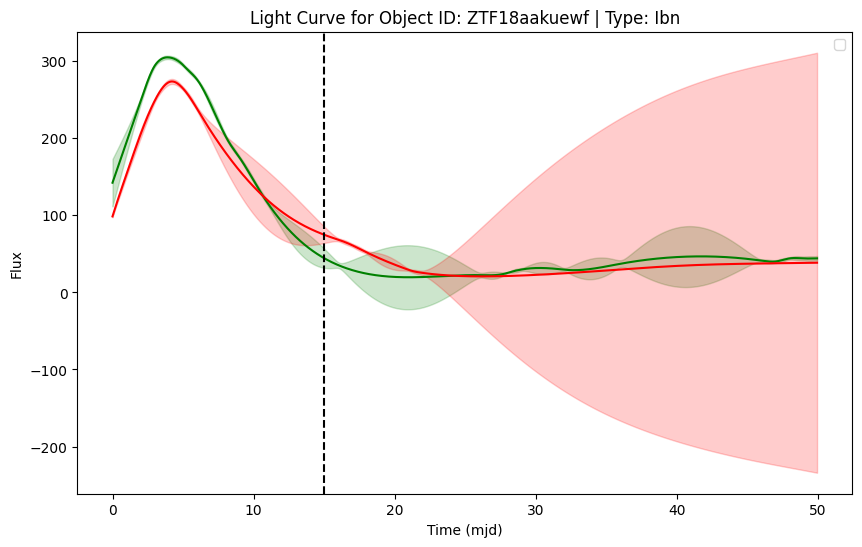

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


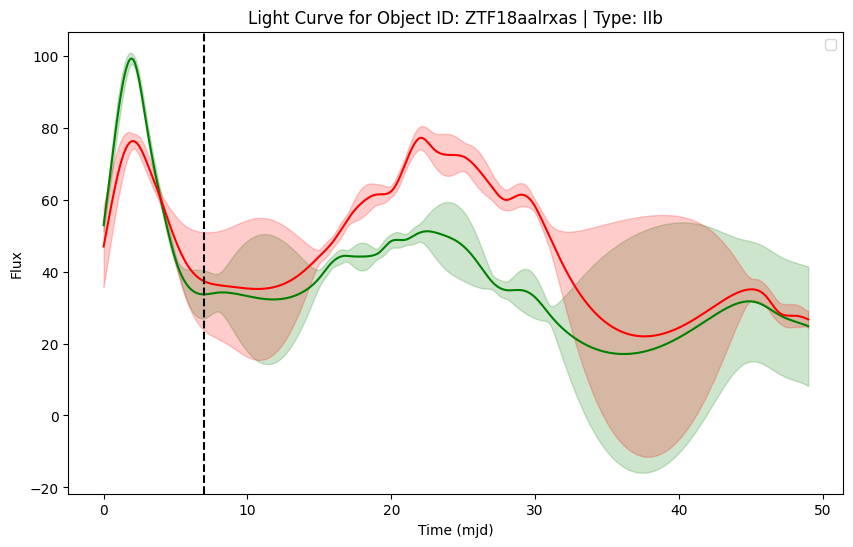

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


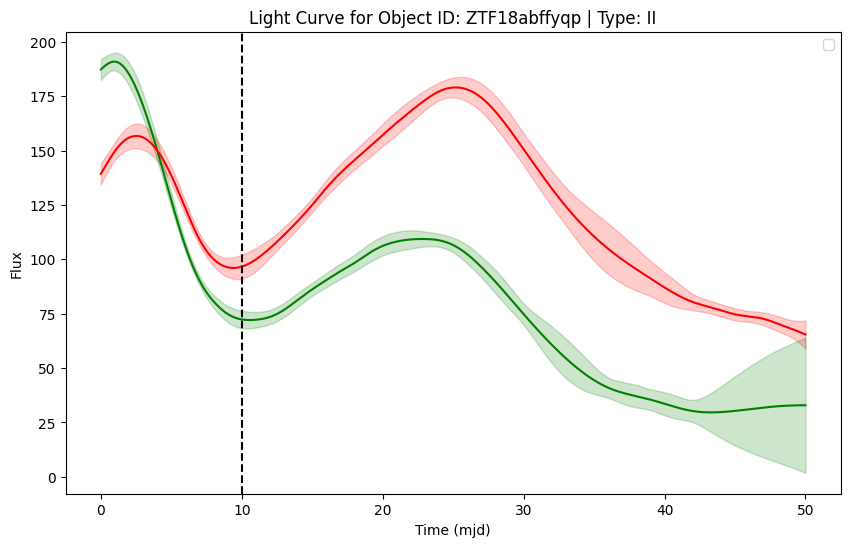

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


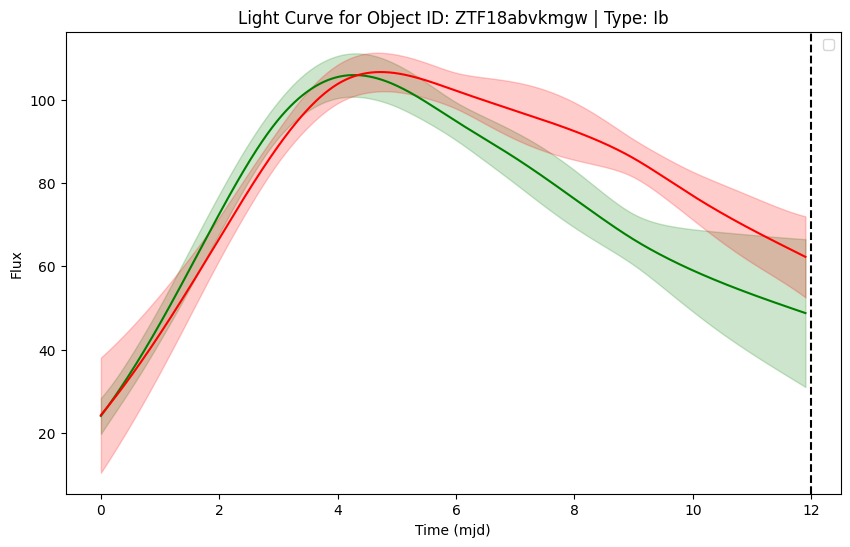

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


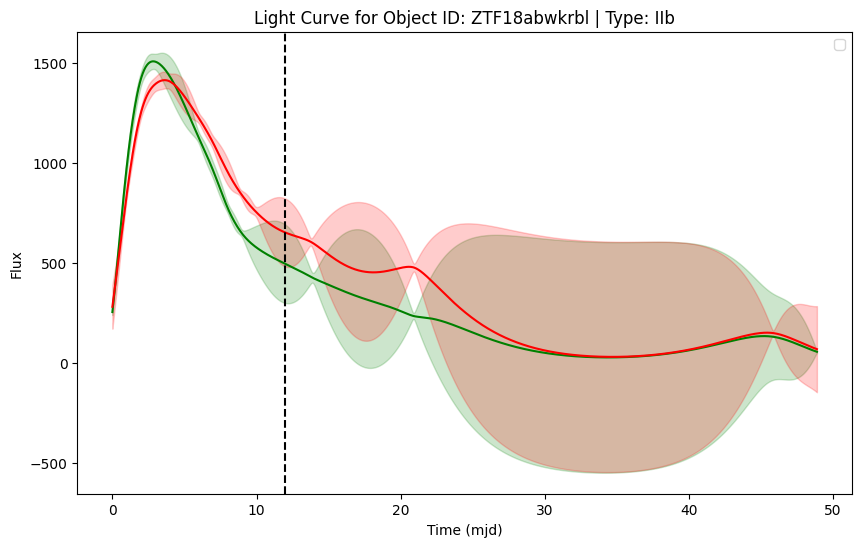

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


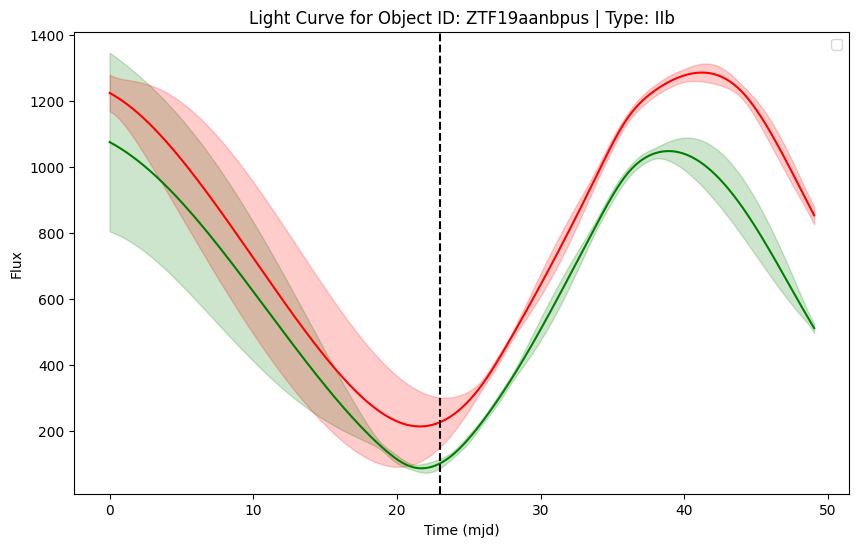

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


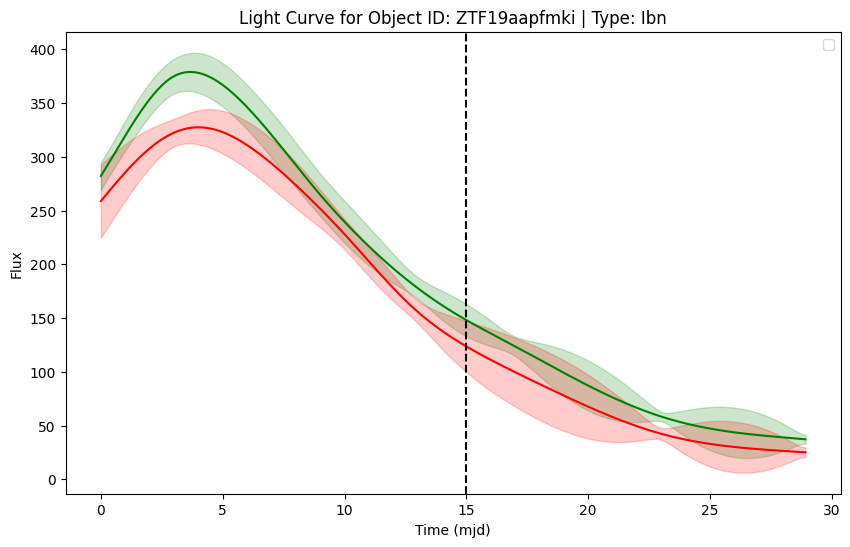

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


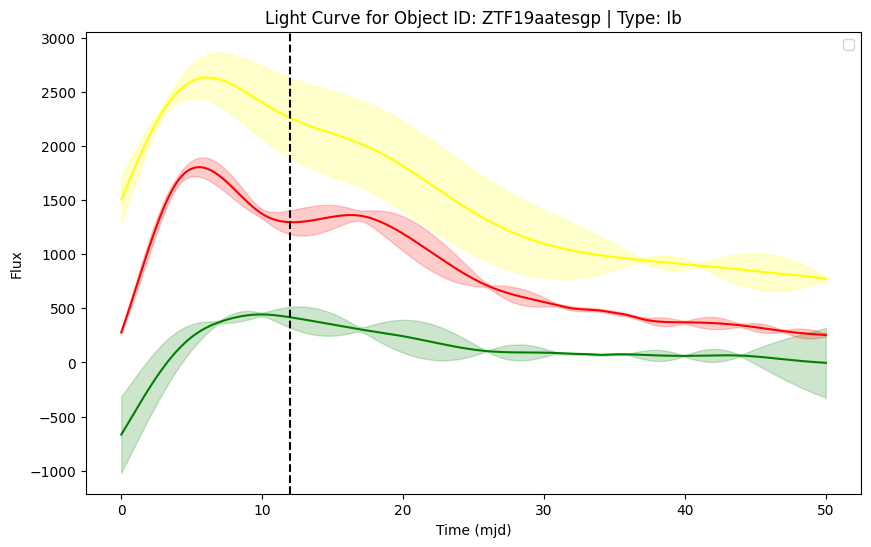

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


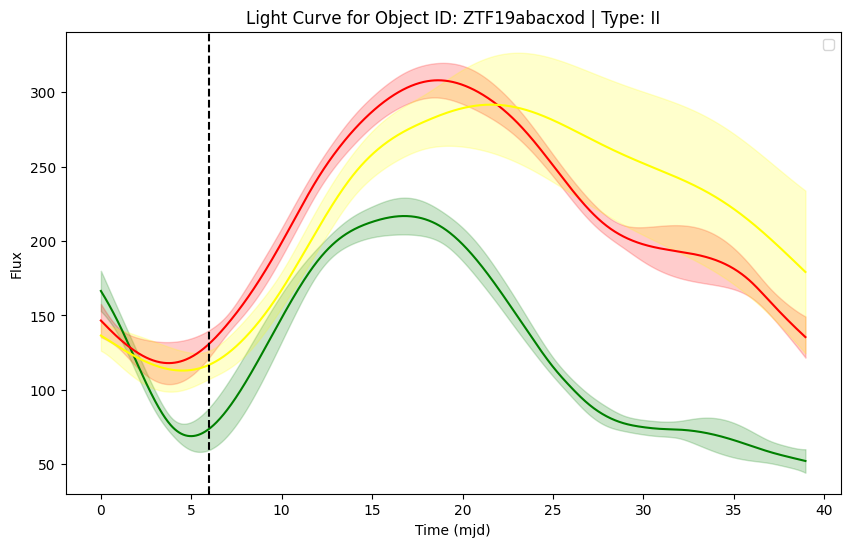

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


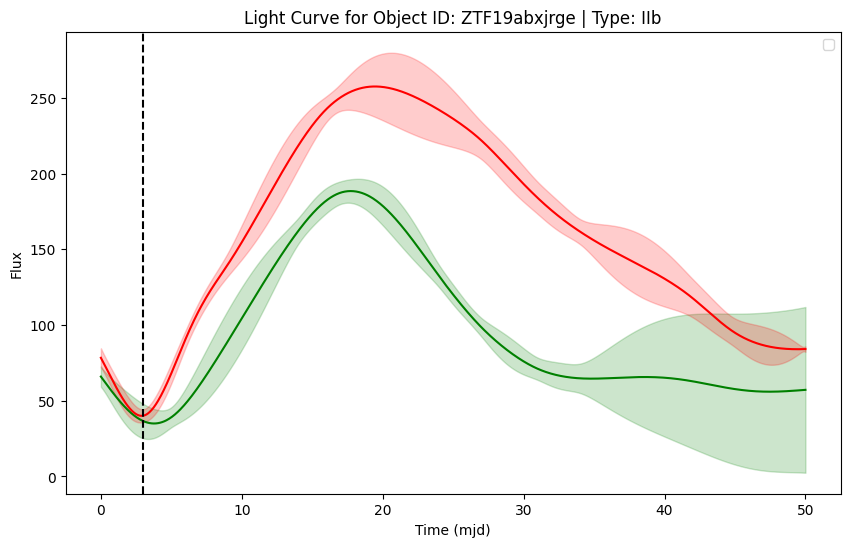

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


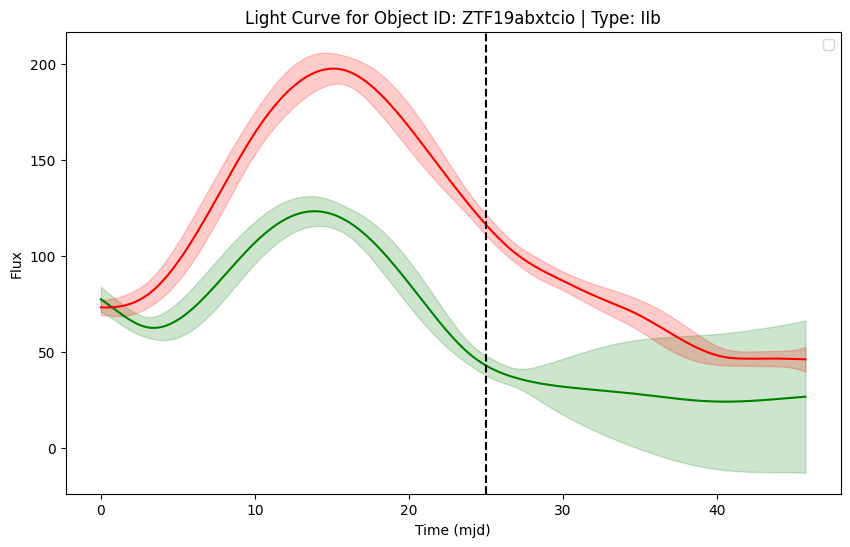

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


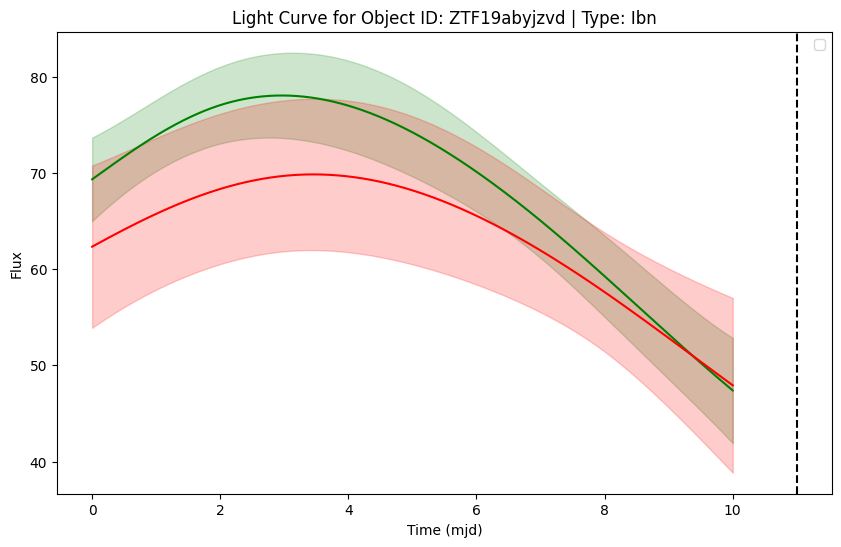

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


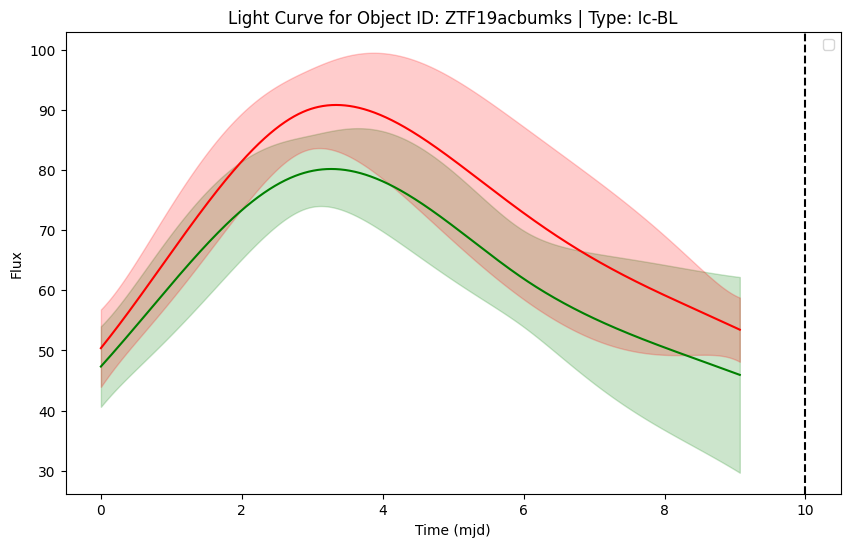

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


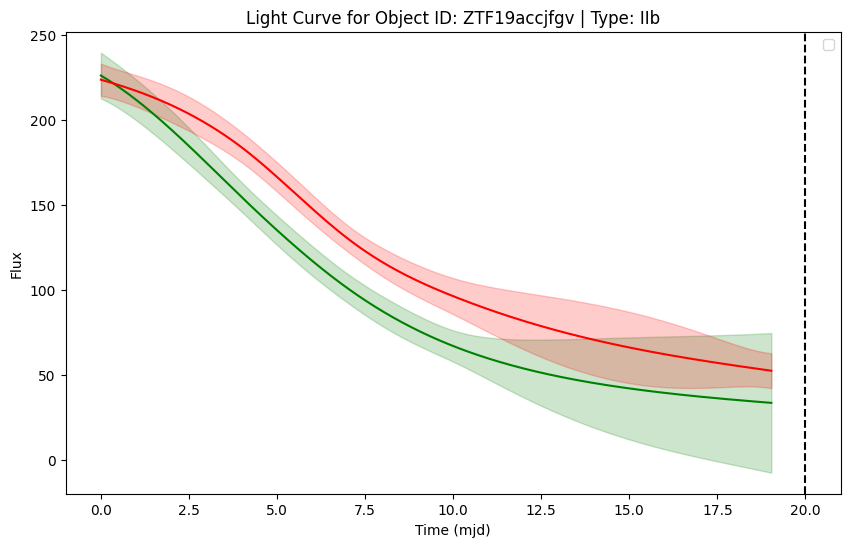

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


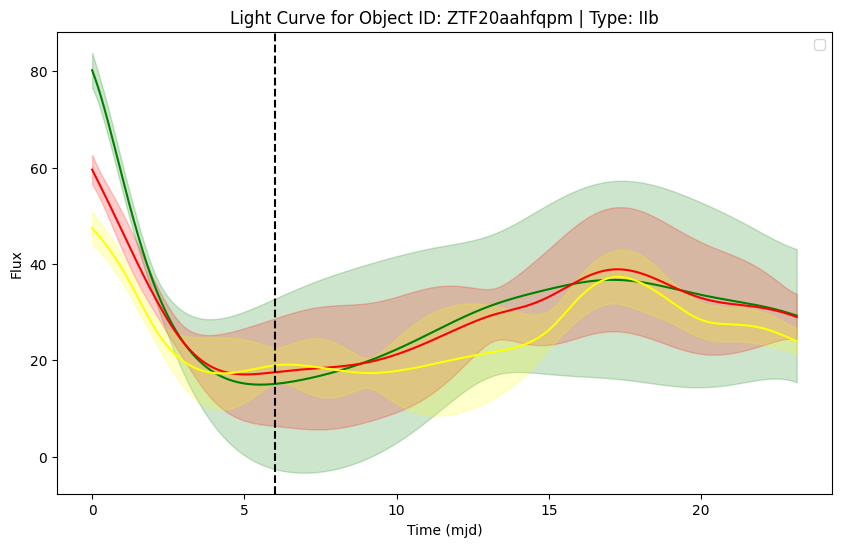

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


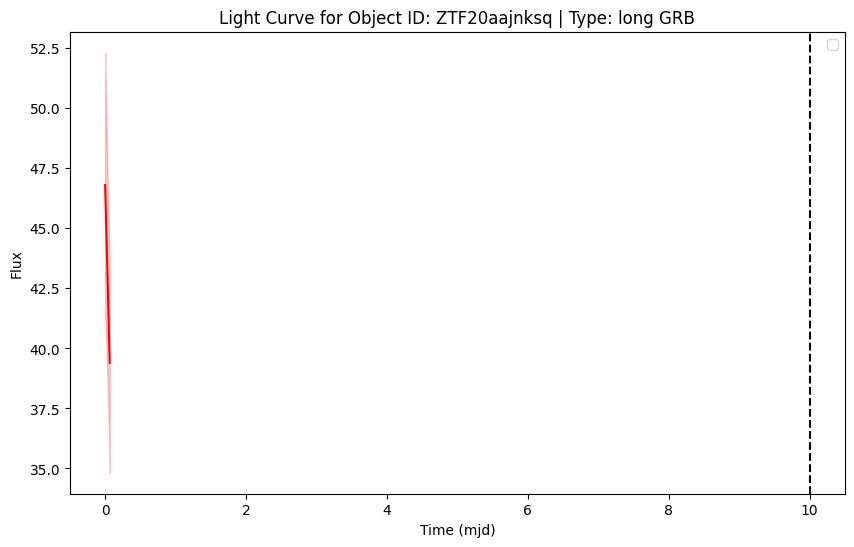

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


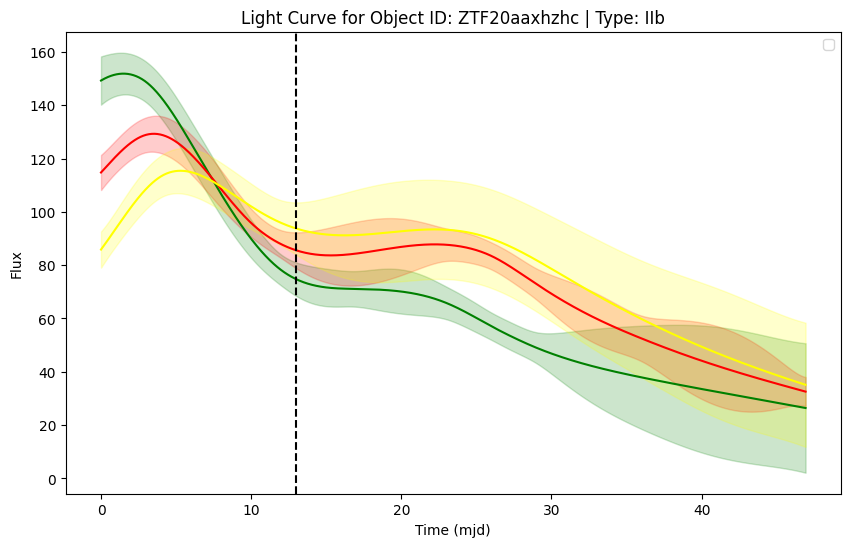

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


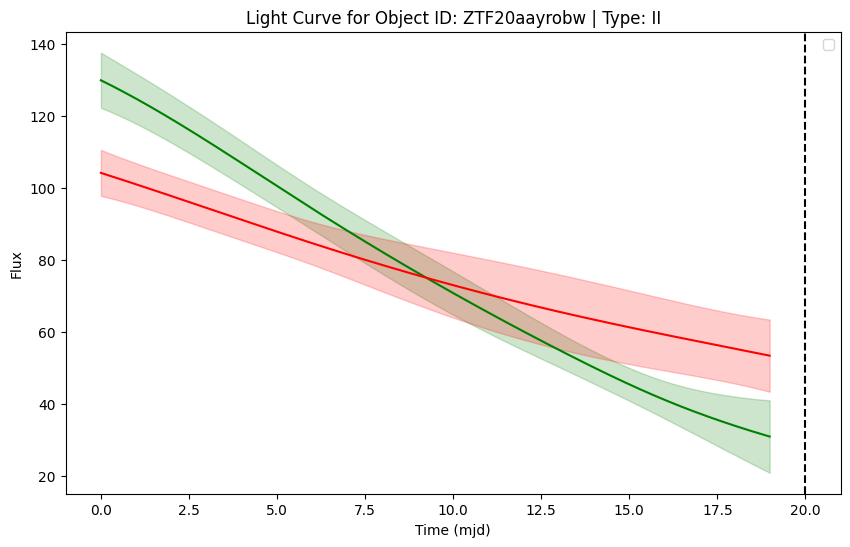

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


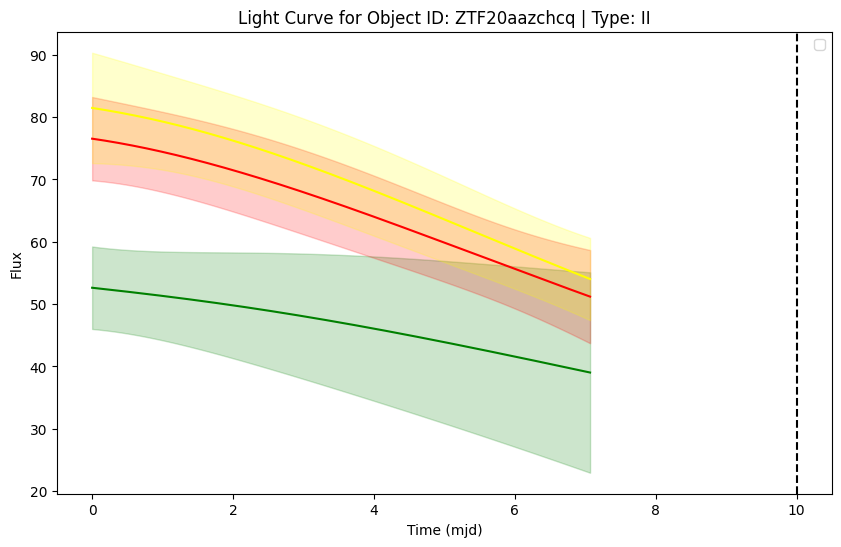

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


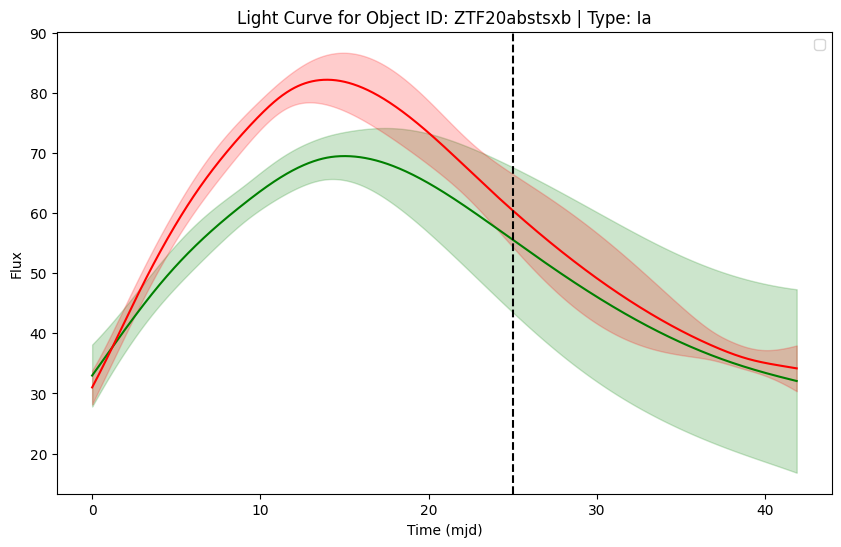

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


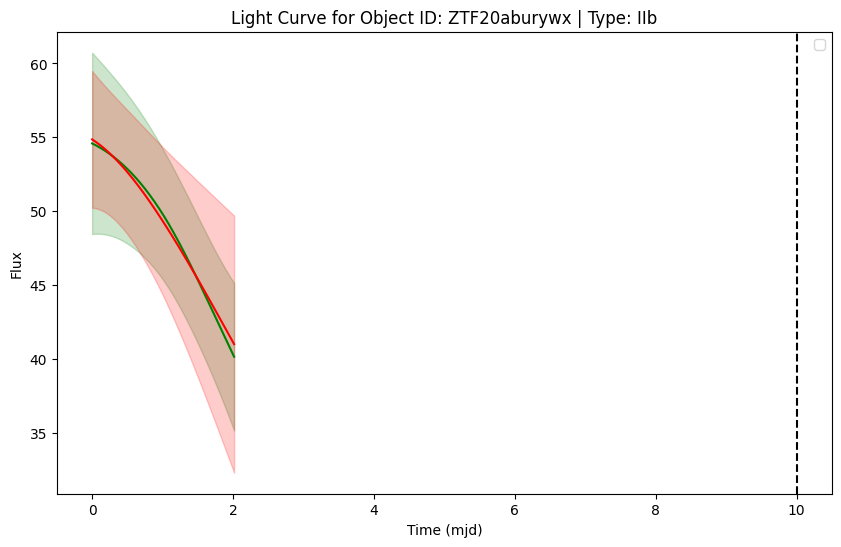

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


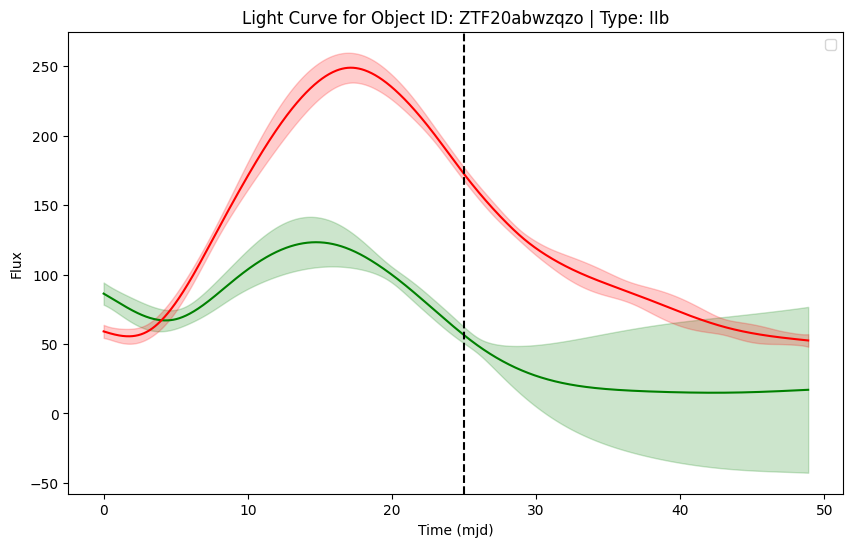

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


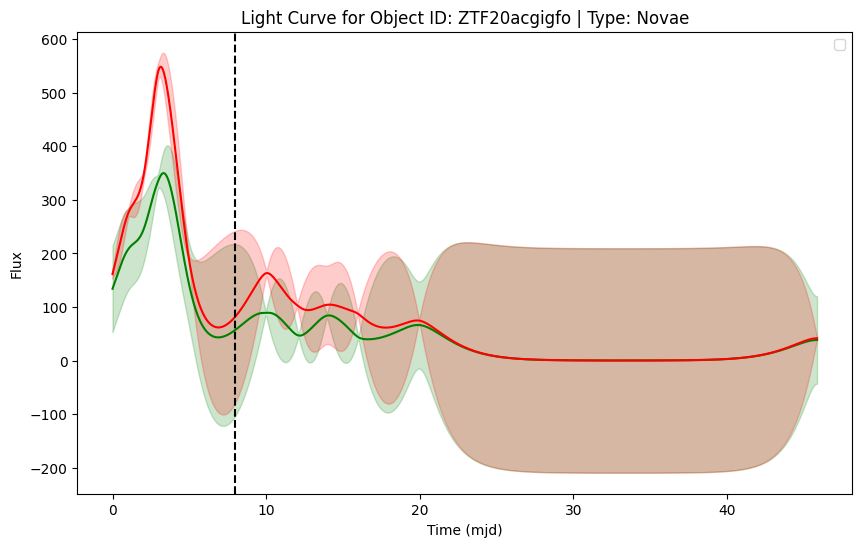

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


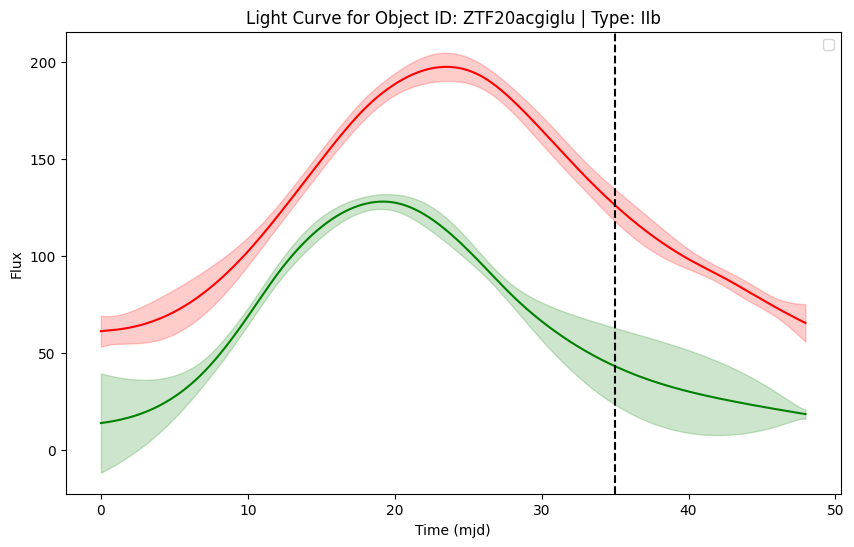

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


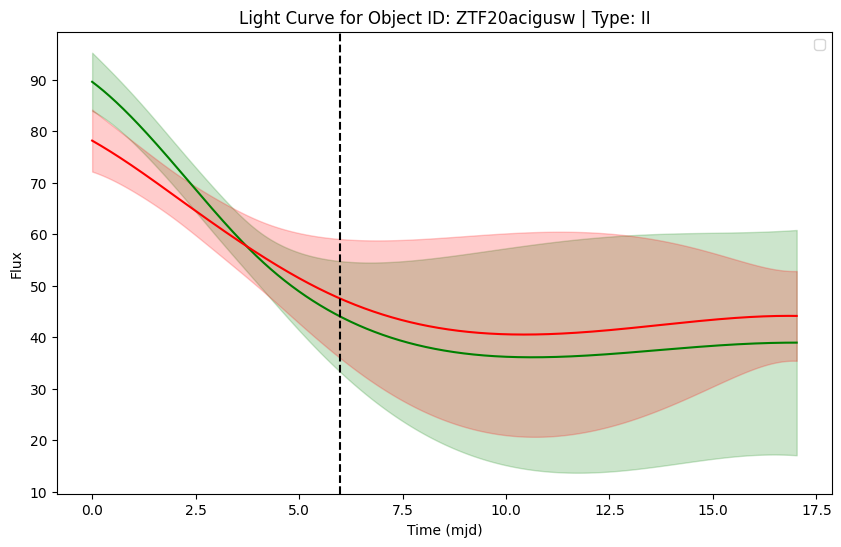

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


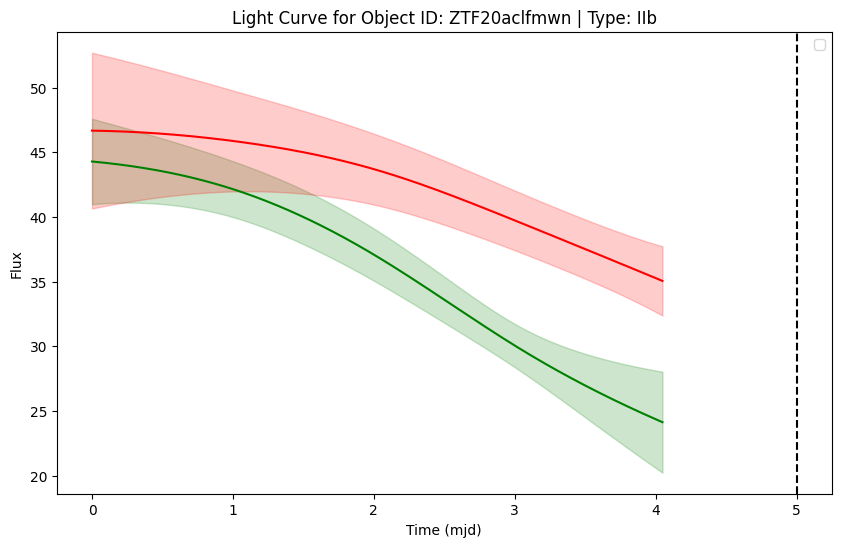

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


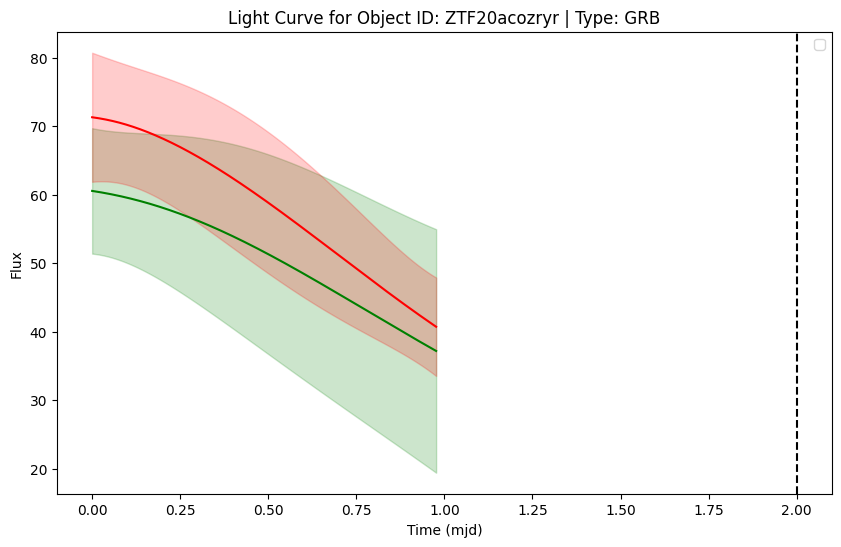

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


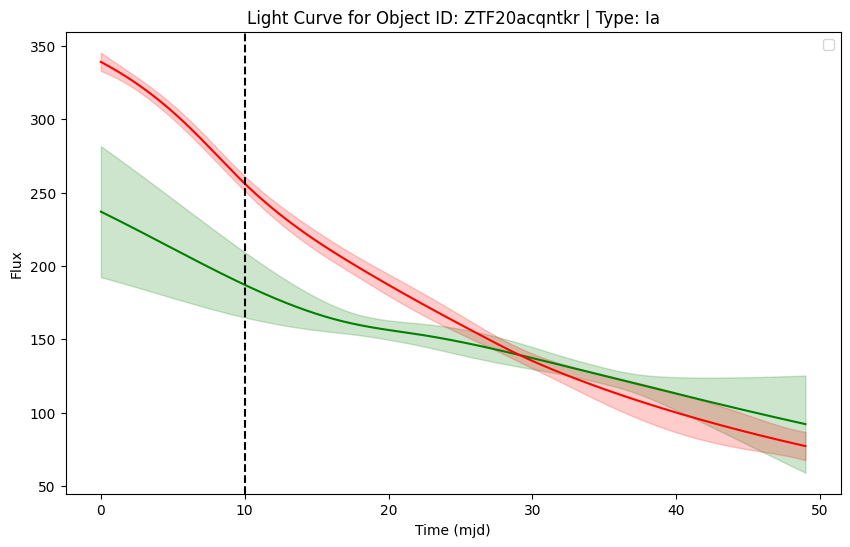

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


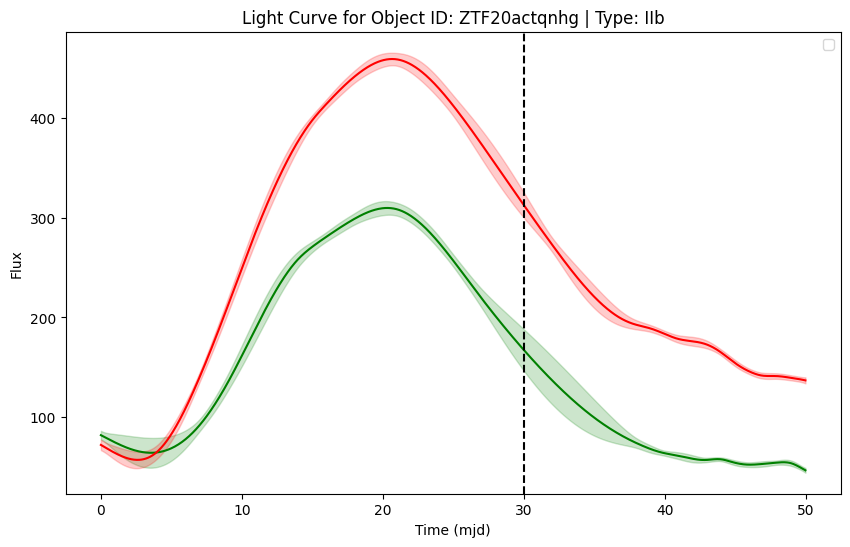

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


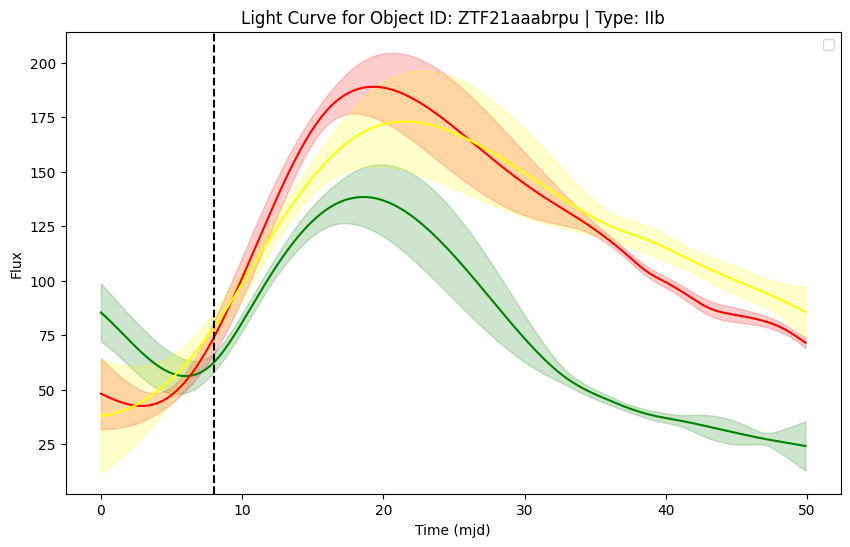

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


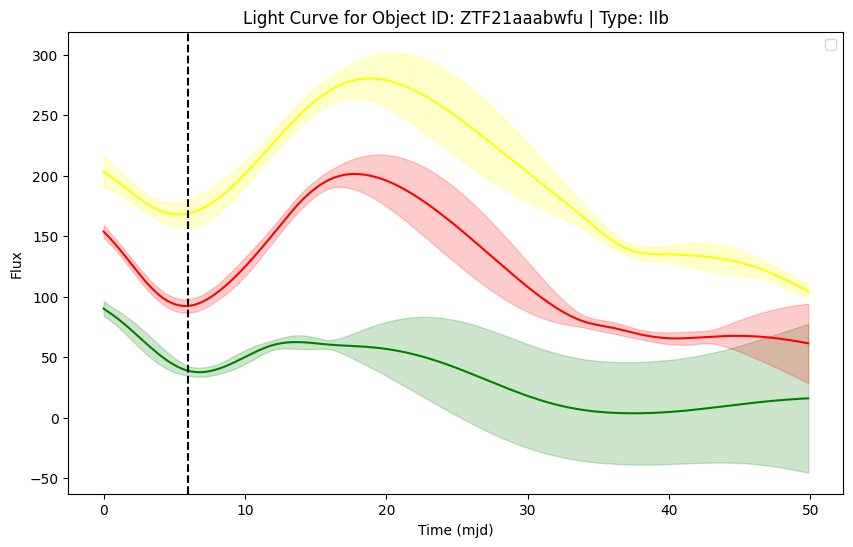

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


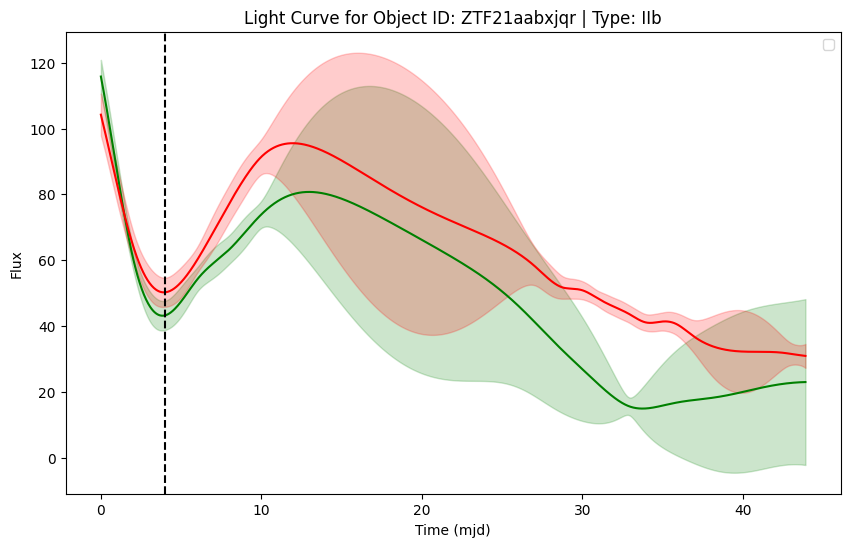

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


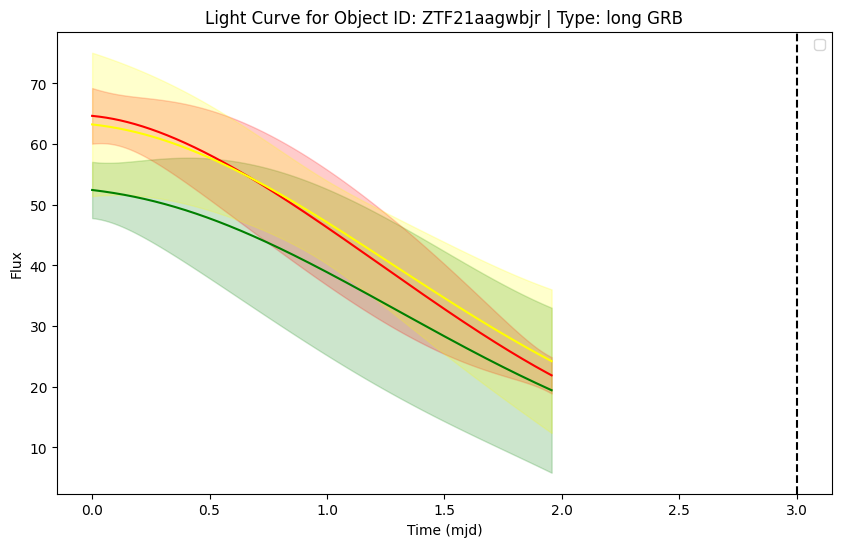

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


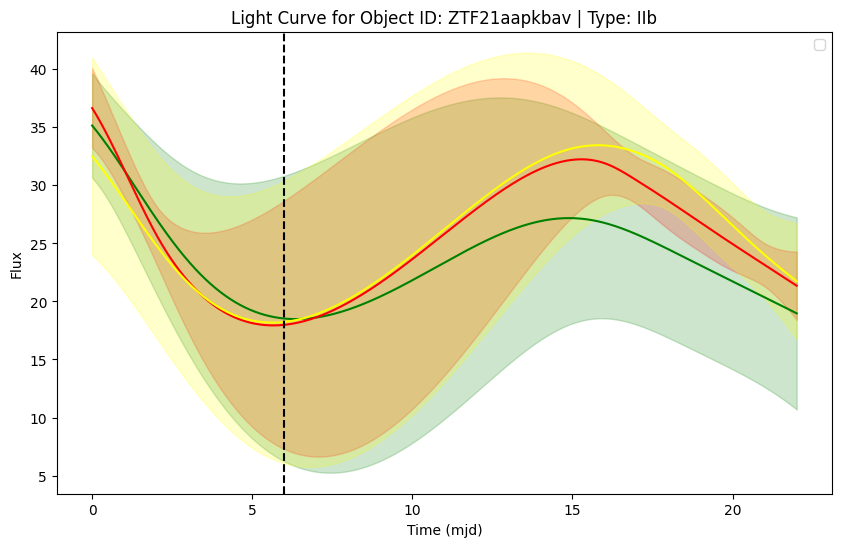

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


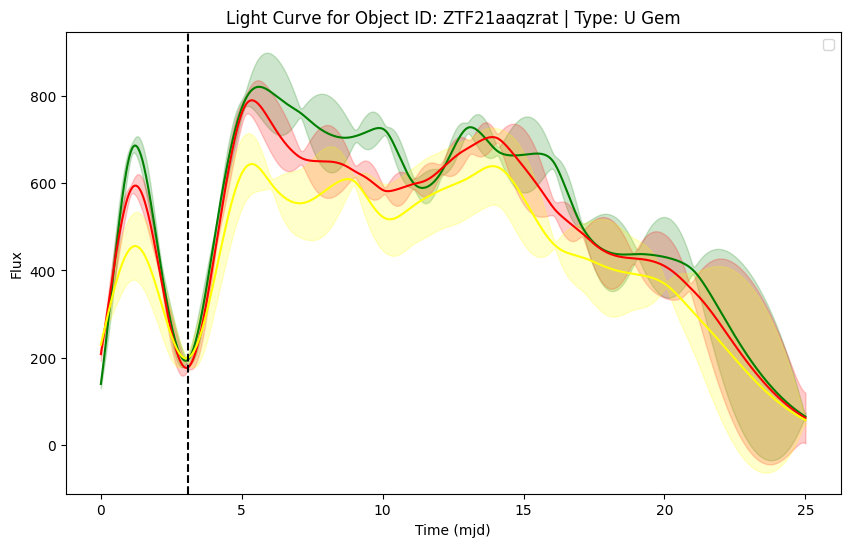

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


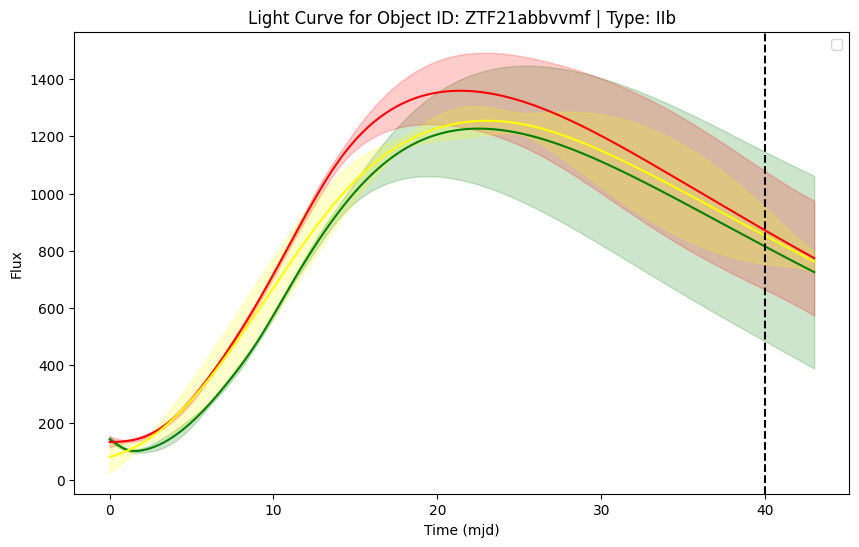

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


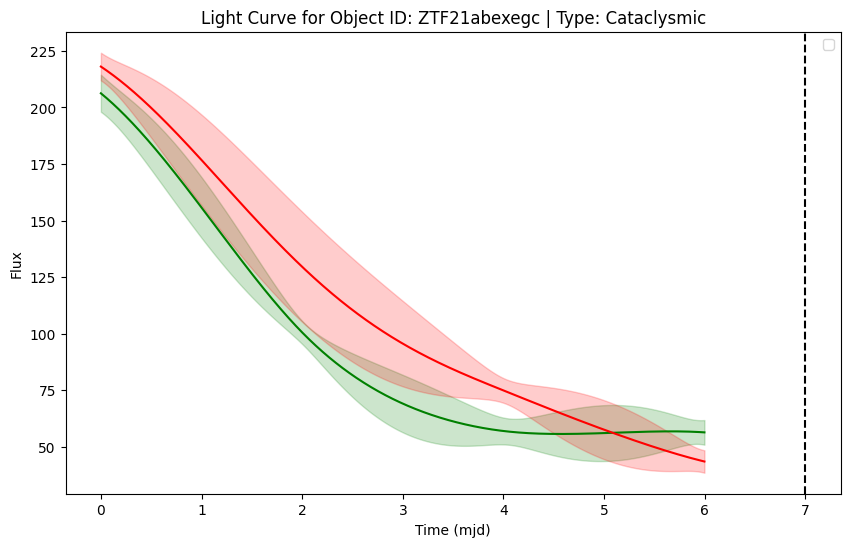

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


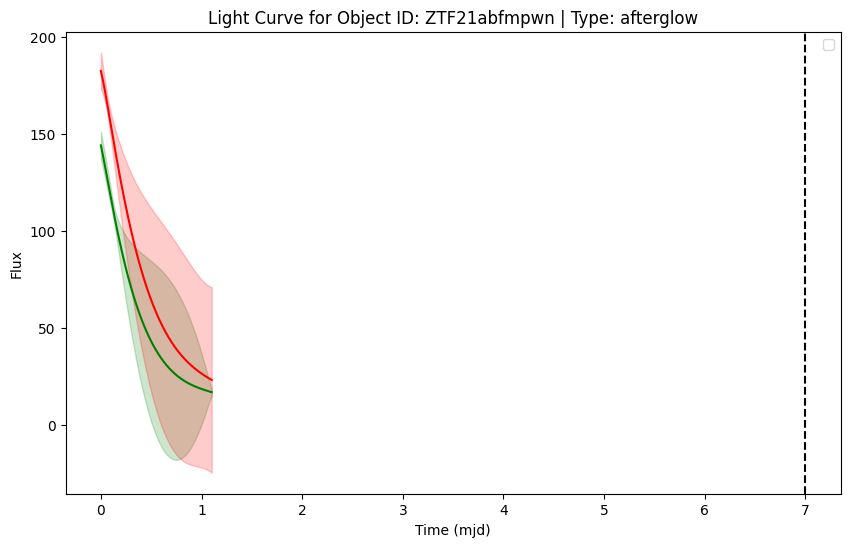

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


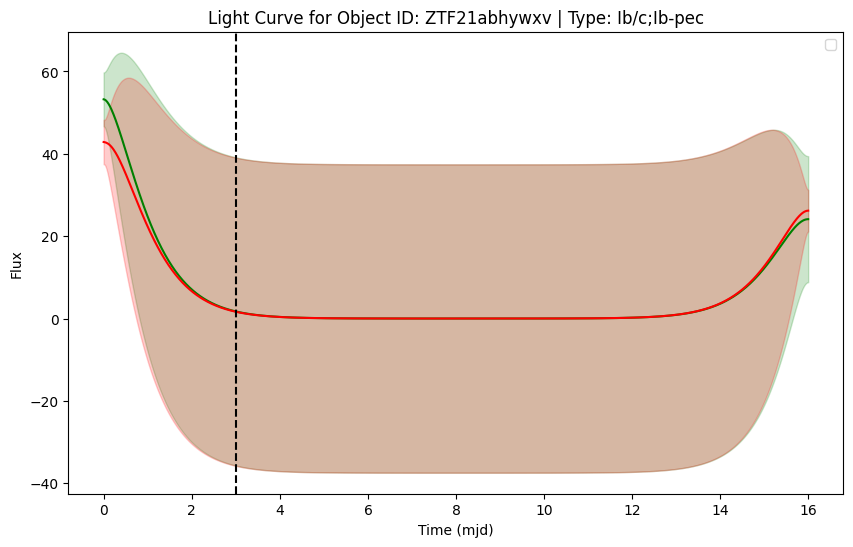

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


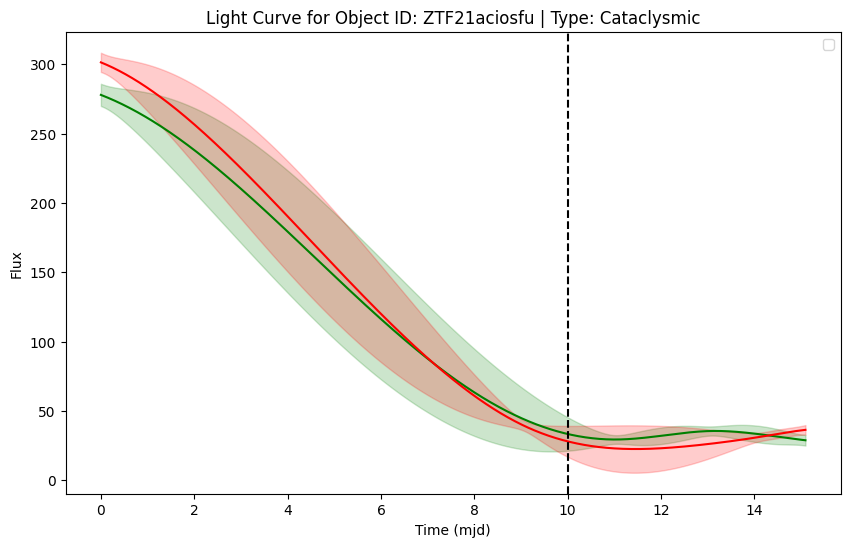

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


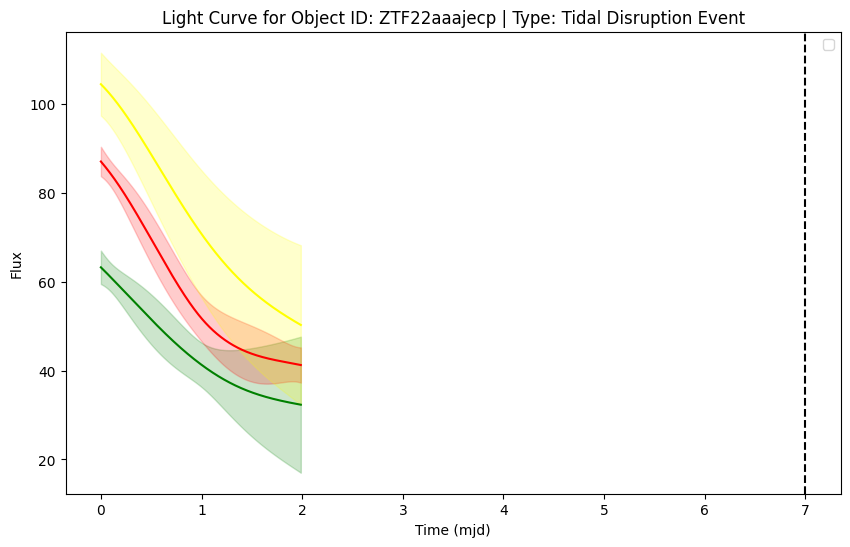

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


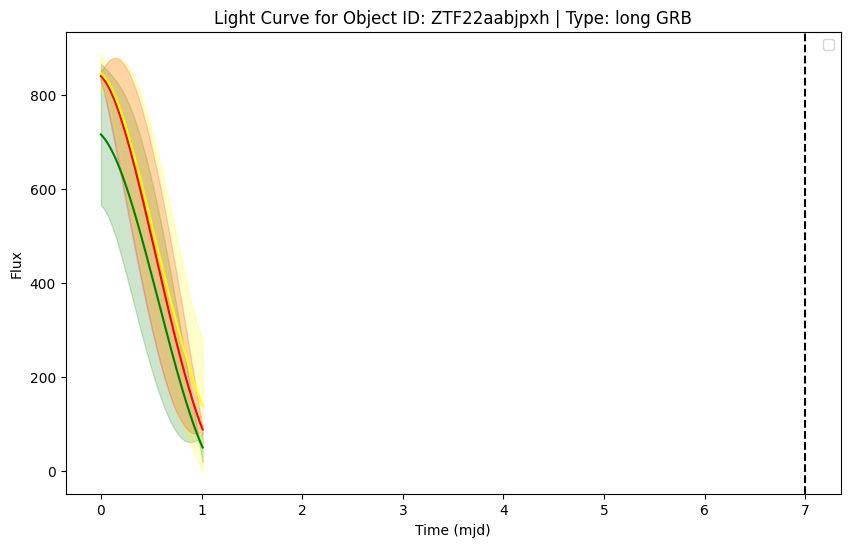

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


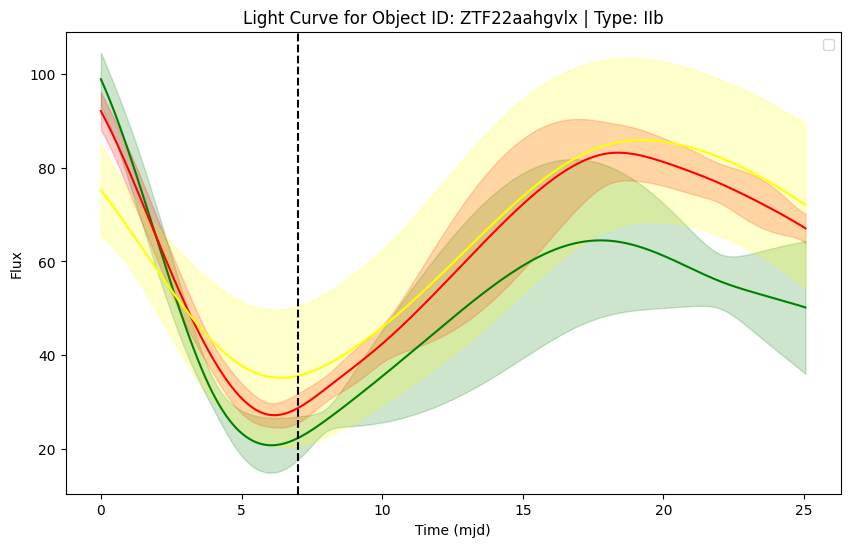

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


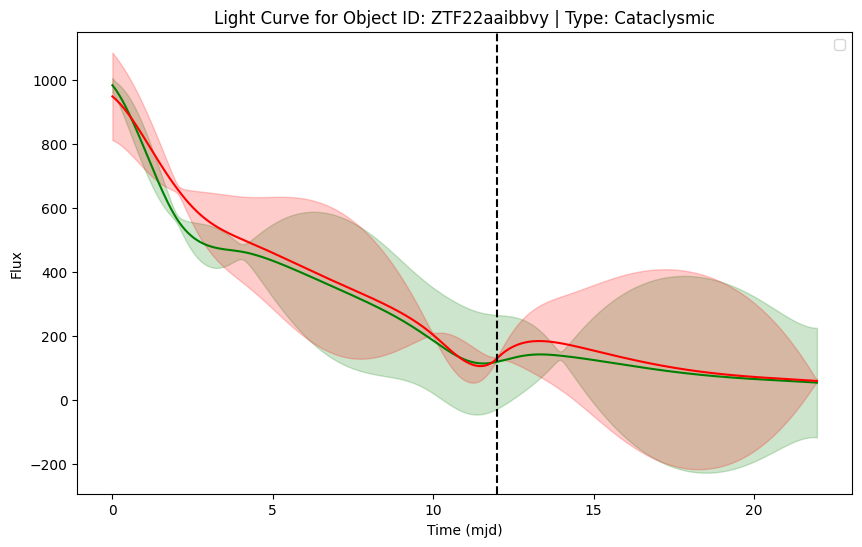

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


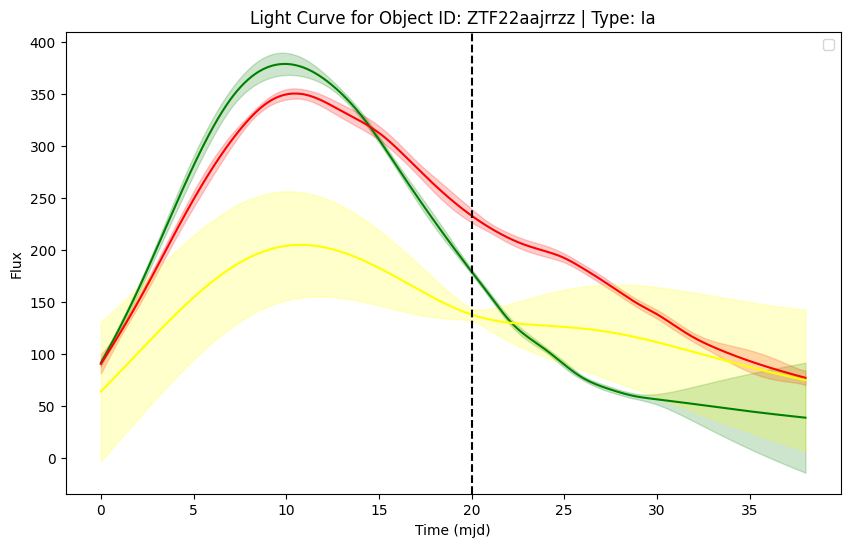

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


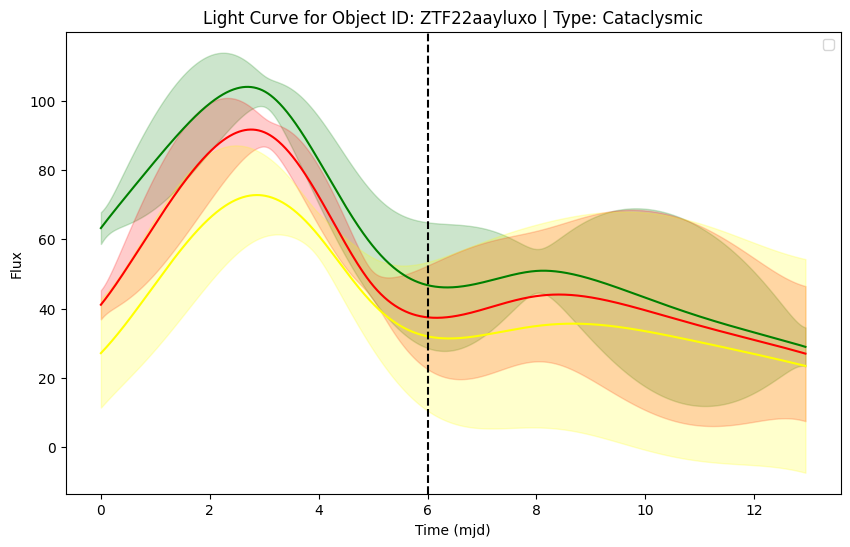

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


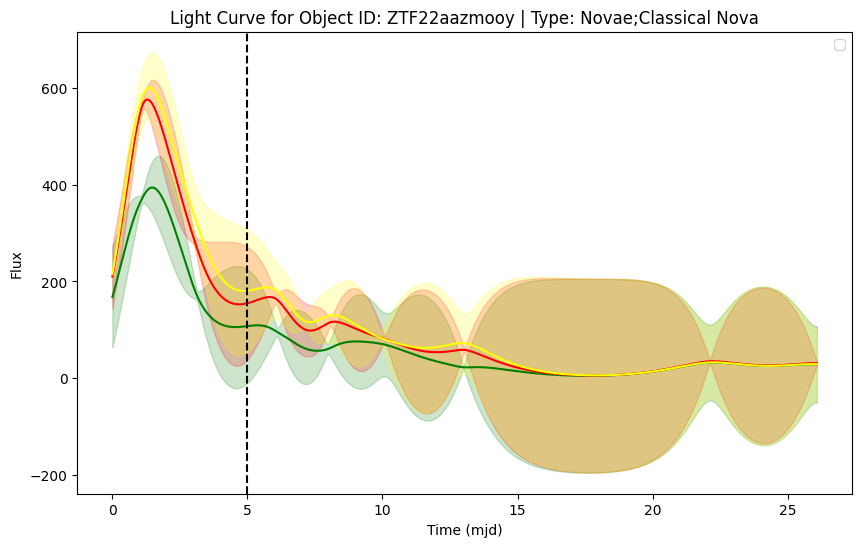

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


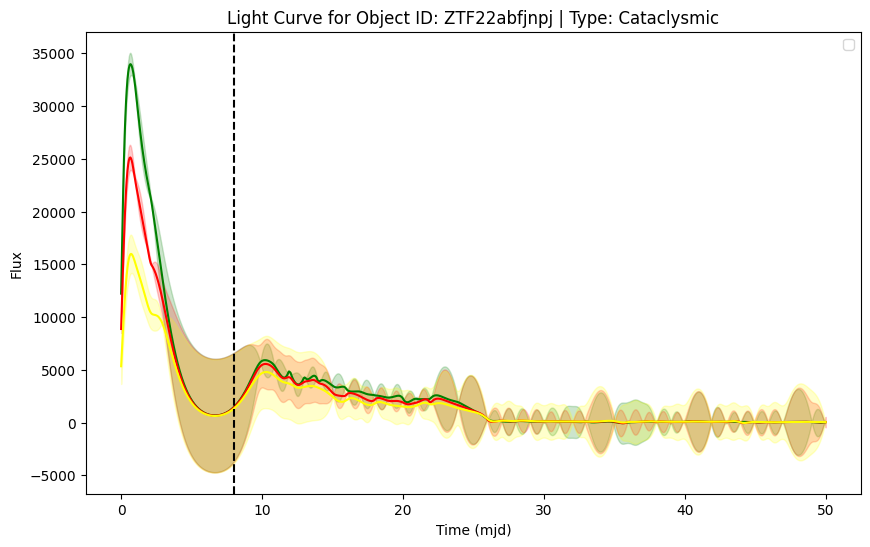

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


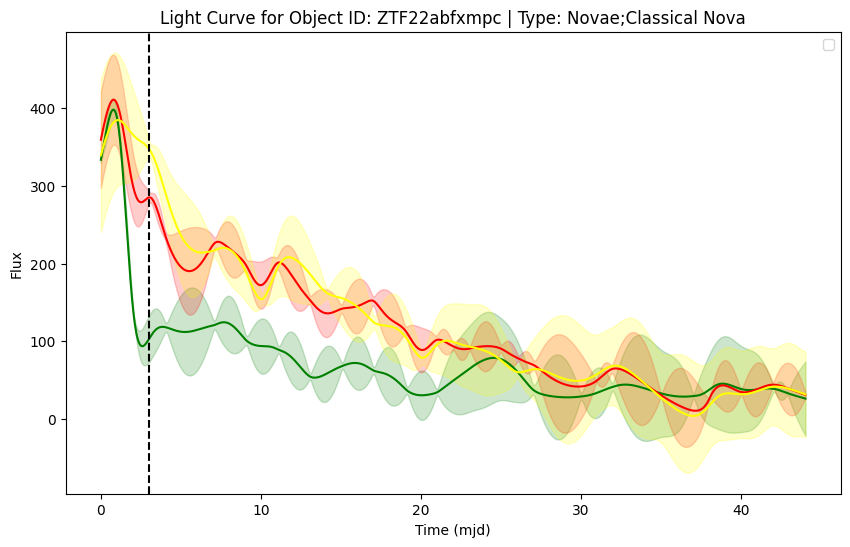

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


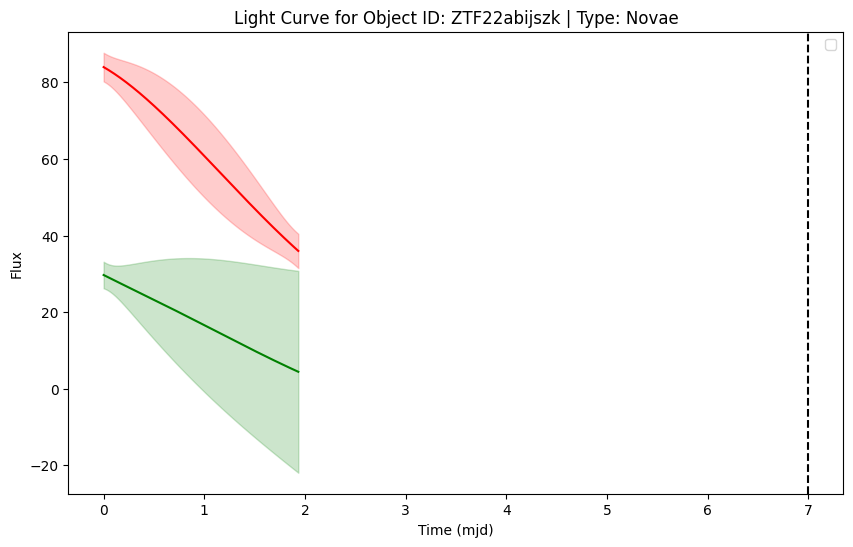

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


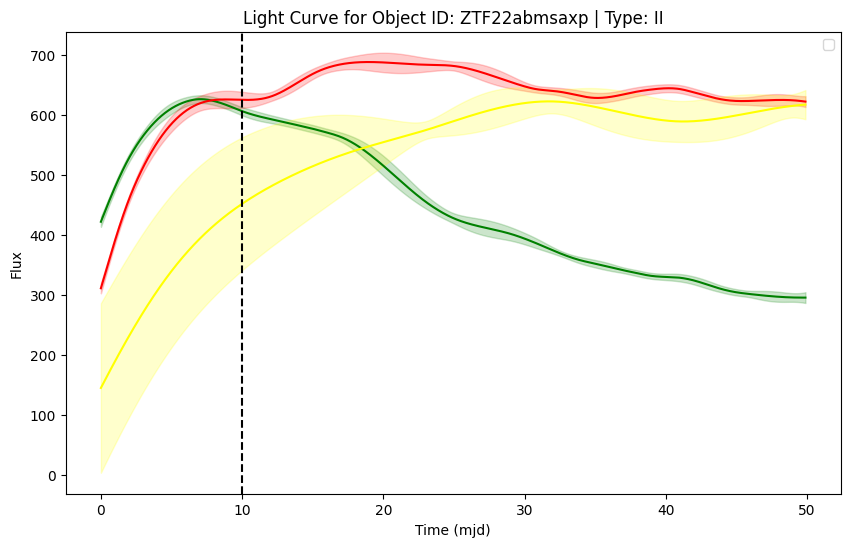

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


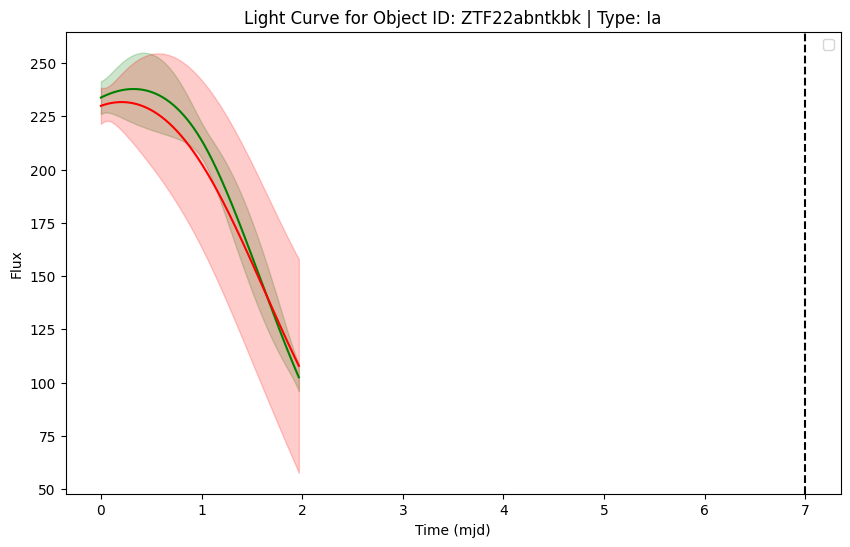

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


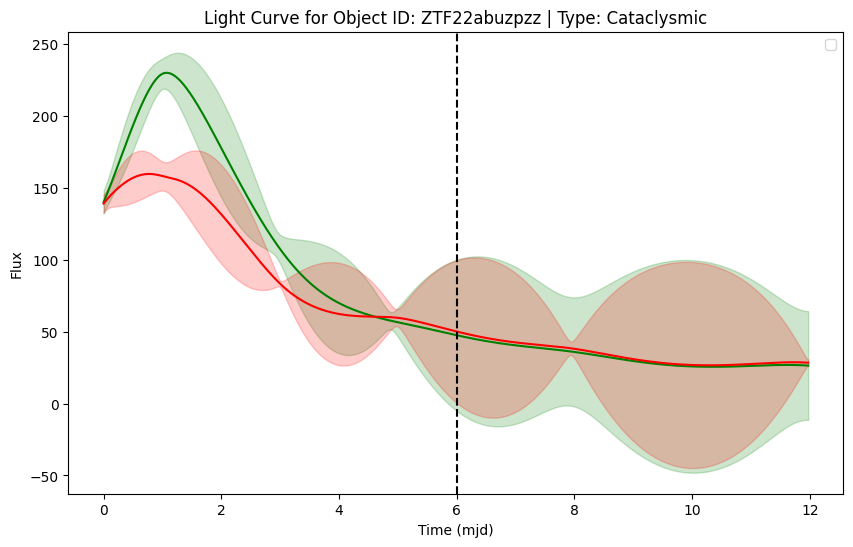

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


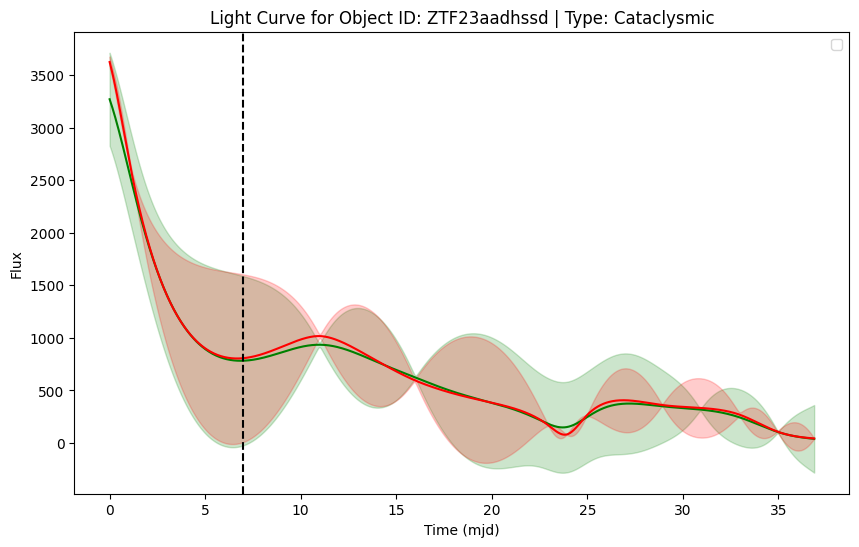

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


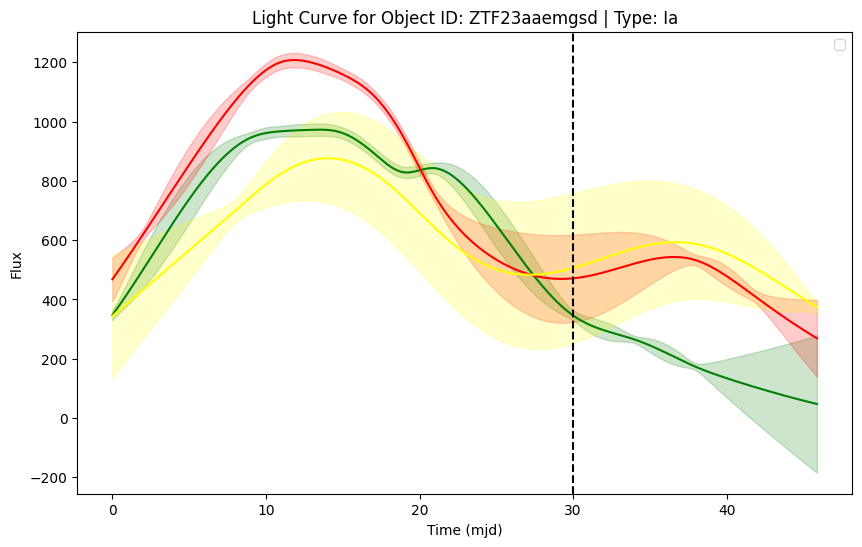

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


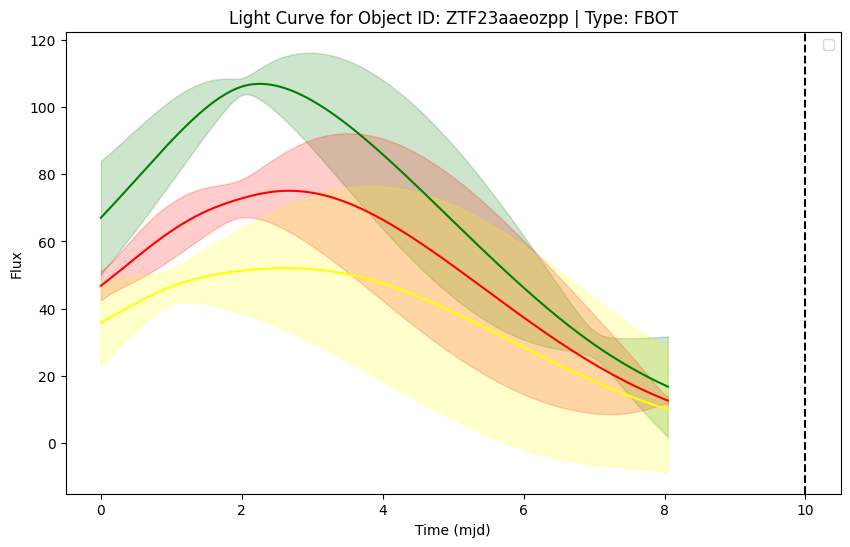

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


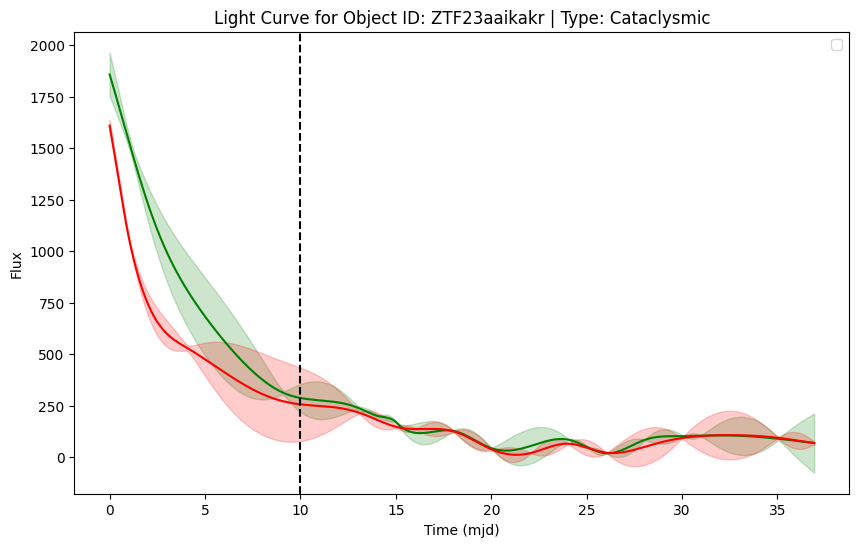

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


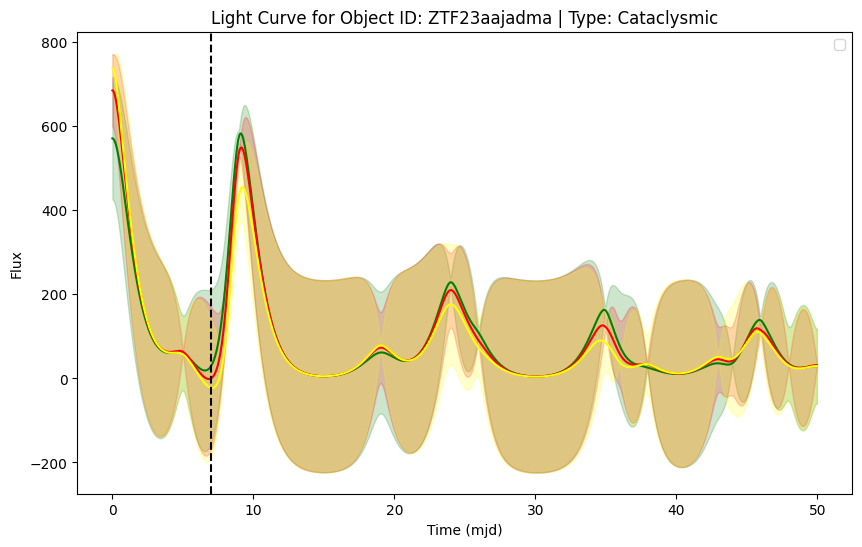

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


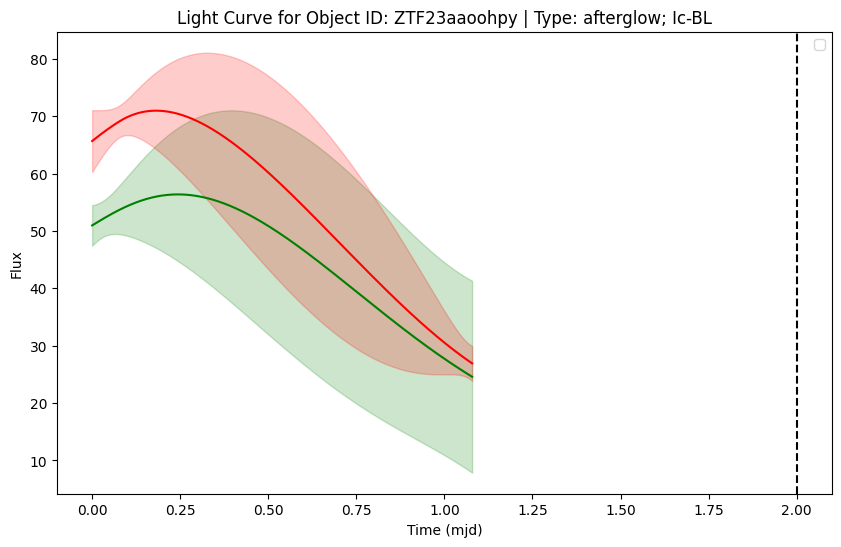

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


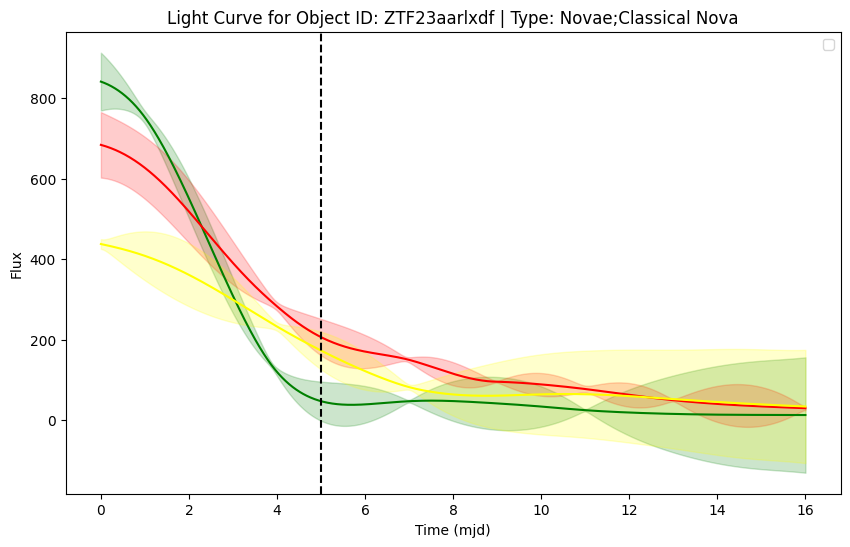

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


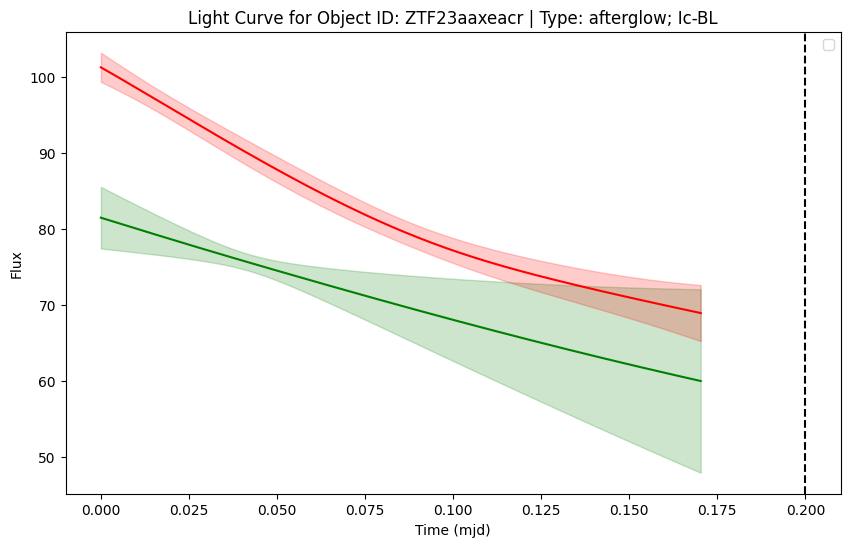

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


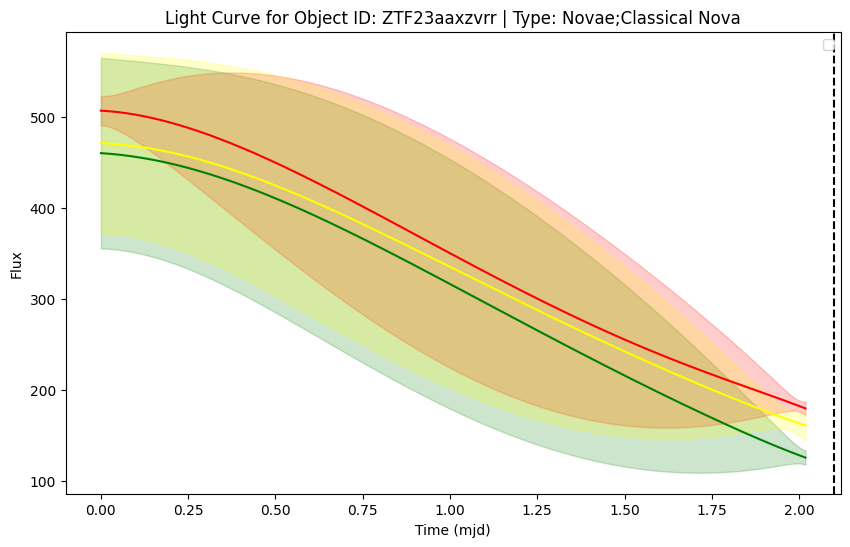

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


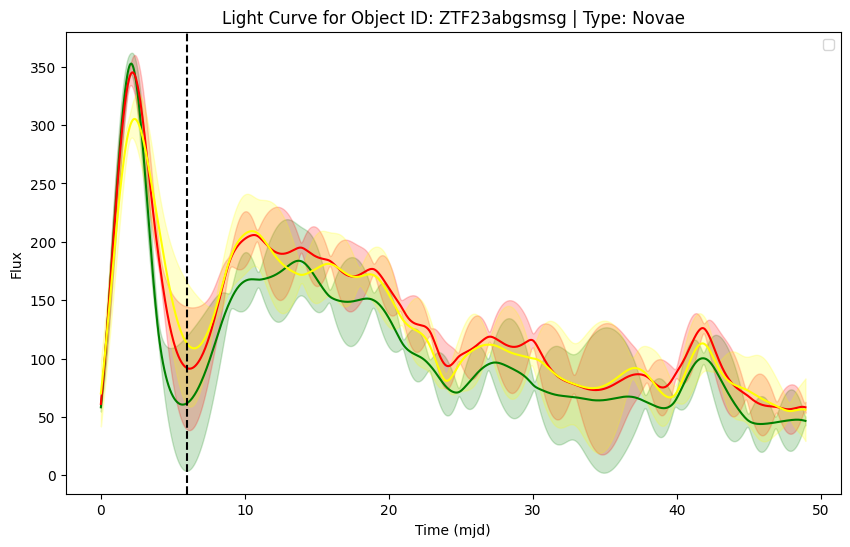

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


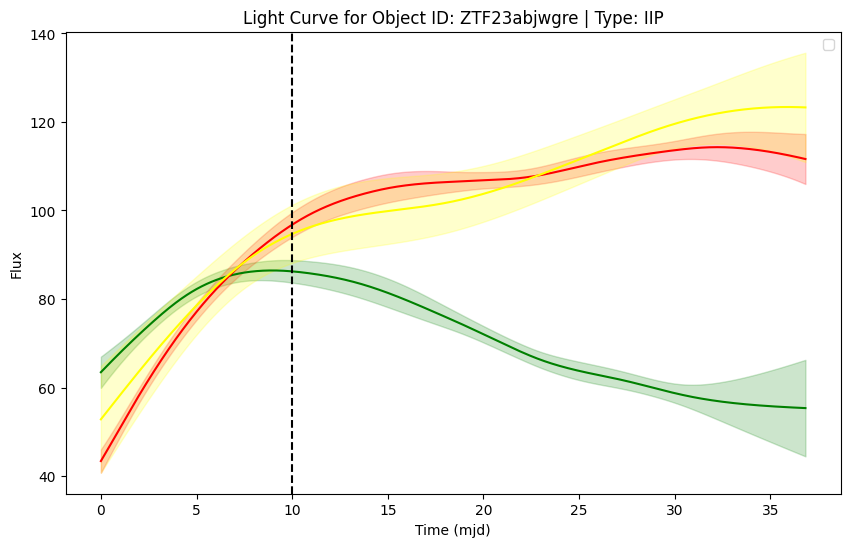

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


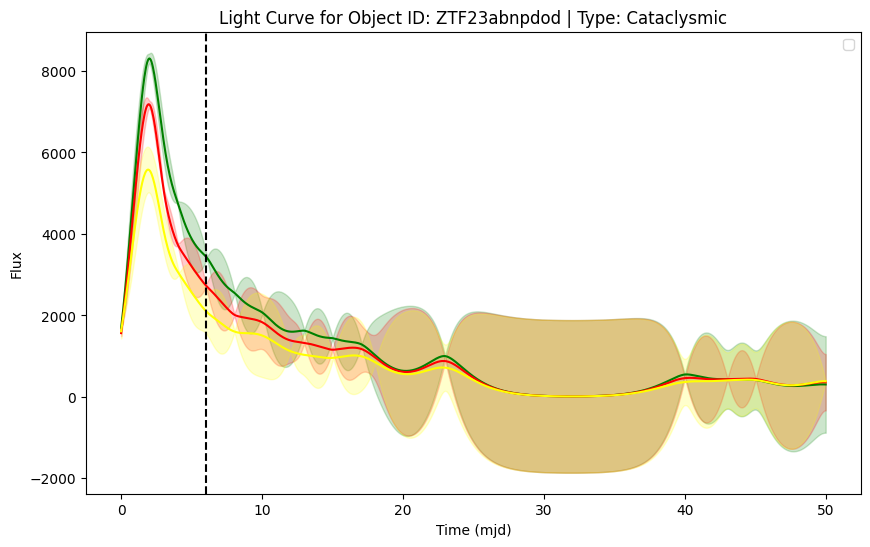

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


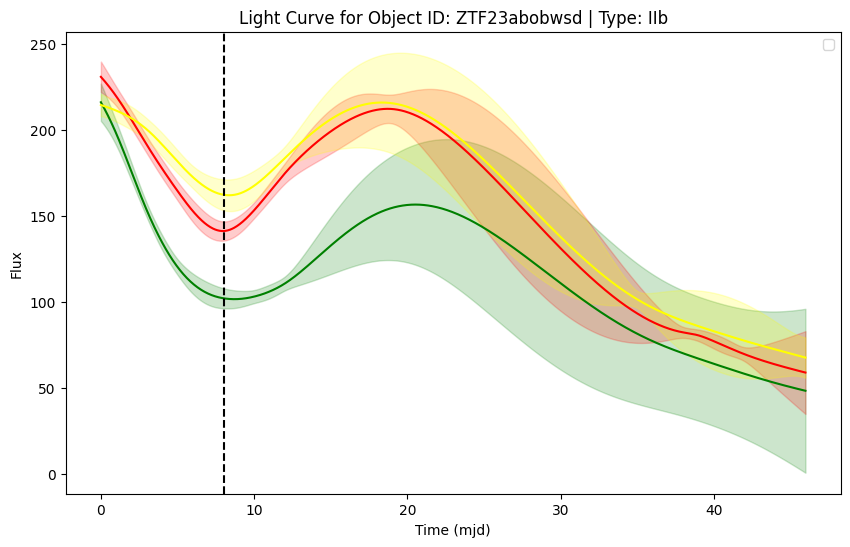

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


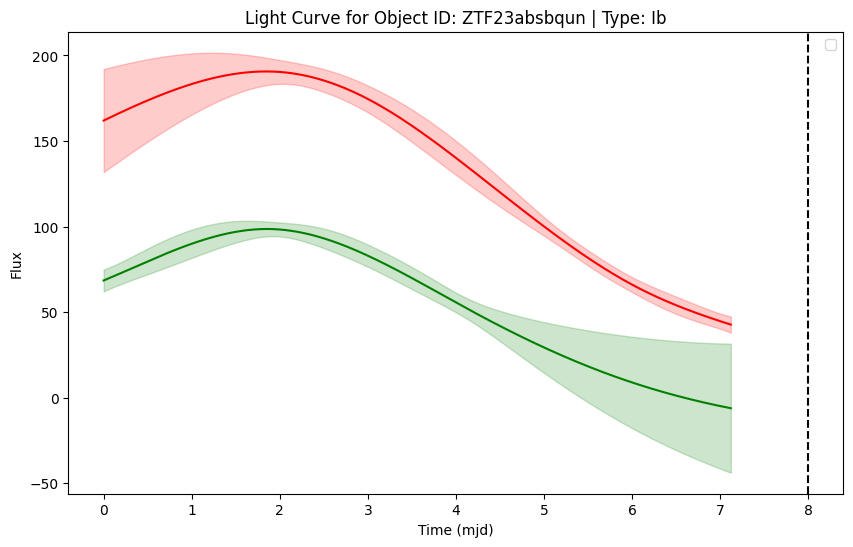

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


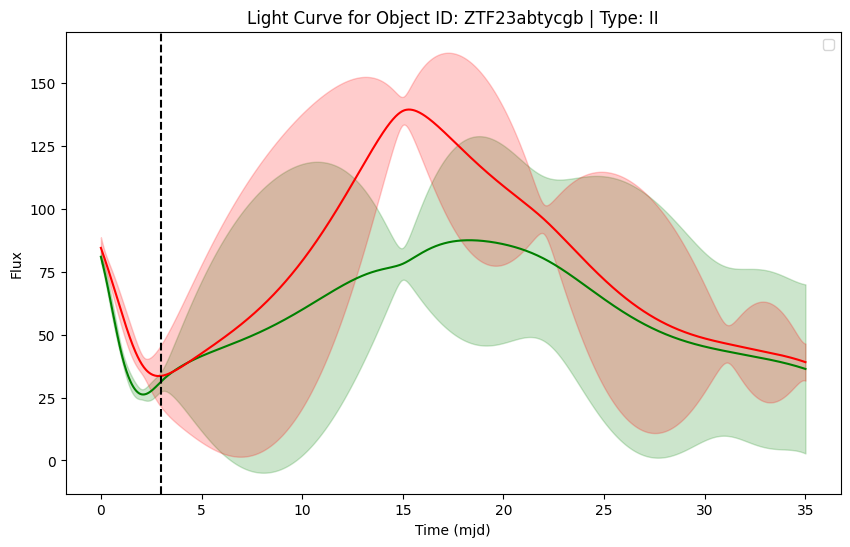

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


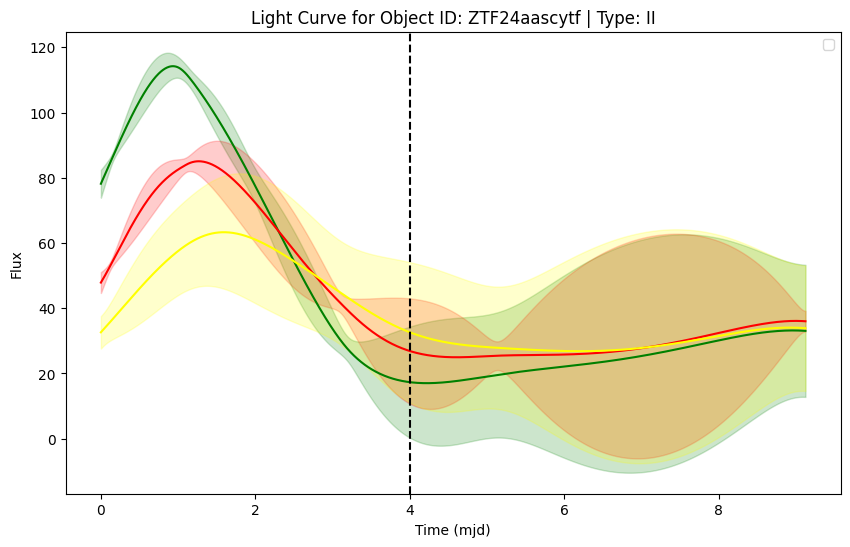

In [ ]:
df = cut_data(df,obj[0], 15)
df = cut_data(df,obj[1], 7)
df = cut_data(df,obj[2], 10)
df = cut_data(df,obj[3], 12)
df = cut_data(df,obj[4], 12)
df = cut_data(df,obj[5], 23)
df = cut_data(df,obj[6], 15)
df = cut_data(df,obj[7], 12)
df = cut_data(df,obj[8], 6)
df = cut_data(df,obj[9], 3)
df = cut_data(df,obj[10], 25)
df = cut_data(df,obj[11], 11)
df = cut_data(df,obj[12], 10)
df = cut_data(df,obj[13], 20)
df = cut_data(df,obj[14], 6)
df = cut_data(df,obj[15], 10)
df = cut_data(df,obj[16], 13)
df = cut_data(df,obj[17], 20)
df = cut_data(df,obj[18], 10)
df = cut_data(df,obj[19], 25)
df = cut_data(df,obj[20], 10)
df = df[df['obj_id'] != obj[21]] ## ztfabwysqy not suited to GP
df = cut_data(df,obj[22], 25)
df = cut_data(df,obj[23], 8)
df = cut_data(df,obj[24], 35)
df = cut_data(df,obj[25], 6)
df = cut_data(df,obj[26], 5)
df = cut_data(df,obj[27], 2)
df = cut_data(df,obj[28], 10)
df = cut_data(df,obj[29], 30)
df = cut_data(df,obj[30], 8)
df = cut_data(df,obj[31], 6)
df = cut_data(df,obj[32], 4)
df = cut_data(df,obj[33], 3)
df = cut_data(df,obj[34], 6)
df = cut_data(df,obj[35], 3.1)
df = cut_data(df,obj[36], 40)
df = cut_data(df,obj[37], 7)
df = cut_data(df,obj[38], 7)
df = cut_data(df,obj[39], 3)
df = cut_data(df,obj[40], 10)
df = cut_data(df,obj[41], 7)
df = cut_data(df,obj[42], 7)
df = cut_data(df,obj[43], 7)
df = cut_data(df,obj[44], 12)
df = cut_data(df,obj[45], 20)
df = cut_data(df,obj[46], 6)
df = cut_data(df,obj[47], 5)
df = cut_data(df,obj[48], 8)
df = cut_data(df,obj[49], 3)
df = cut_data(df,obj[50], 7)
df = cut_data(df,obj[51], 10)
df = cut_data(df,obj[52], 7)
df = cut_data(df,obj[53], 6)
df = df[df['obj_id'] != obj[54]]
df = cut_data(df,obj[55], 7)
df = cut_data(df,obj[56], 30)
df = cut_data(df,obj[57], 10)
df = cut_data(df,obj[58], 10)
df = df[df['obj_id'] != obj[59]]
df = cut_data(df,obj[60], 7)
df = cut_data(df,obj[61], 2)
df = cut_data(df,obj[62], 5)
df = cut_data(df,obj[63], 0.2)
df = cut_data(df,obj[64], 2.1)
df = cut_data(df,obj[65], 6)
df = cut_data(df,obj[66], 10)
df = cut_data(df,obj[67], 6)
df = cut_data(df,obj[68], 8)
df = df[df['obj_id'] != obj[69]]
df = cut_data(df,obj[70], 8)
df = cut_data(df,obj[71], 3)
df = cut_data(df,obj[72], 4)


In [12]:
df[df['obj_id'] == obj[-1]]

mjd  flux_ztfg  flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
72001  60646.432303  36.331010  25.066002         2.034971         3.157210   
72002  60646.438415  36.878915  25.505385         1.897780         2.788540   
72003  60646.444527  37.431393  25.949203         1.804559         2.448082   
72004  60646.450639  37.987503  26.397472         1.755290         2.151762   
72005  60646.456751  38.546301  26.850209         1.748509         1.923001   
...             ...        ...        ...              ...              ...   
72996  60652.513689  33.493383  40.961798         3.488673         5.252959   
72997  60652.519801  33.463261  40.930338         3.842217         5.054402   
72998  60652.525913  33.432509  40.895906         4.235472         4.909244   
72999  60652.532025  33.401076  40.858402         4.657035         4.823773   
73000  60652.538137  33.368917  40.817727         5.098662         4.802653   

      type        obj_id         mjd_0  redshift  flux_ztfi  ...   mag_ztfg  \
72001  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...  19.999306   
72002  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...  19.983055   
72003  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...  19.966910   
72004  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...  19.950898   
72005  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...  19.935043   
...    ...           ...           ...       ...        ...  ...        ...   
72996  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...  20.087602   
72997  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...  20.088579   
72998  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...  20.089578   
72999  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...  20.090599   
73000  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...  20.091645   

       abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  mag_error_ztfr  \
72001    -11.010249        0.060814  20.402287    -10.607268        0.136755   
72002    -11.026501        0.055872  20.383420    -10.626135        0.118705   
72003    -11.042646        0.052343  20.364690    -10.644866        0.102430   
72004    -11.058657        0.050169  20.346094    -10.663461        0.088503   
72005    -11.074512        0.049250  20.327631    -10.681925        0.077760   
...             ...             ...        ...           ...             ...   
72996    -10.921953        0.113090  19.869052    -11.140503        0.139235   
72997    -10.920976        0.124663  19.869887    -11.139669        0.134075   
72998    -10.919978        0.137549  19.870800    -11.138755        0.130334   
72999    -10.918957        0.151382  19.871797    -11.137759        0.128183   
73000    -10.917911        0.165897  19.872878    -11.136678        0.127749   

       mag_ztfi  abs_mag_ztfi  mag_error_ztfi         t  
72001       NaN           NaN             NaN  0.000000  
72002       NaN           NaN             NaN  0.006112  
72003       NaN           NaN             NaN  0.012224  
72004       NaN           NaN             NaN  0.018336  
72005       NaN           NaN             NaN  0.024448  
...         ...           ...             ...       ...  
72996       NaN           NaN             NaN  6.081386  
72997       NaN           NaN             NaN  6.087498  
72998       NaN           NaN             NaN  6.093610  
72999       NaN           NaN             NaN  6.099721  
73000       NaN           NaN             NaN  6.105833  

[1000 rows x 21 columns]

In [14]:
# df = pd.read_csv('gp_objects_gp1000.csv')
rise_fade = pd.read_csv('gp_rise_fade_stats.csv')
rise_fade

Object  rise fade notes
0   ZTF18aakuewf    y    y   NaN
1   ZTF18aalrxas    y    y   NaN
2   ZTF18abffyqp    y    y   NaN
3   ZTF18abvkmgw    y    y   NaN
4   ZTF18abwkrbl    y    y   NaN
..           ...  ...  ...   ...
65  ZTF23abobwsd    n    y   NaN
66  ZTF23absbqun    y    y   NaN
67  ZTF23abtycgb    n    y   NaN
68  ZTF24aascytf    y    y   NaN
69  ZTF24abvevzs    y    y   NaN

[70 rows x 4 columns]

In [15]:
rise_fade.columns

Index(['Object ', 'rise', 'fade', 'notes'], dtype='object')

In [16]:
# for i in rise_fade['Object ']:
#     df.loc(df['obj_id'] == i)['rise'] = rise_fade[rise_fade['Object '] == i]['rise'].values[0]
#     df.loc(df['obj_id'] == i)['fade'] = rise_fade[rise_fade['Object '] == i]['fade'].values[0]
df_array = []
for object in sorted(rise_fade['Object '].unique()):
    # print(object)
    sub_df = df[df['obj_id'] == object]
    rise = rise_fade[rise_fade['Object '] == object]['rise'].values[0]
    fade = rise_fade[rise_fade['Object '] == object]['fade'].values[0]
    df_array.append(sub_df.assign(rise=rise, fade=fade))
df = pd.concat(df_array)

In [19]:
df[df['obj_id'] == obj[-1]]

mjd  flux_ztfg  flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
72001  60646.432303  36.331010  25.066002         2.034971         3.157210   
72002  60646.438415  36.878915  25.505385         1.897780         2.788540   
72003  60646.444527  37.431393  25.949203         1.804559         2.448082   
72004  60646.450639  37.987503  26.397472         1.755290         2.151762   
72005  60646.456751  38.546301  26.850209         1.748509         1.923001   
...             ...        ...        ...              ...              ...   
72996  60652.513689  33.493383  40.961798         3.488673         5.252959   
72997  60652.519801  33.463261  40.930338         3.842217         5.054402   
72998  60652.525913  33.432509  40.895906         4.235472         4.909244   
72999  60652.532025  33.401076  40.858402         4.657035         4.823773   
73000  60652.538137  33.368917  40.817727         5.098662         4.802653   

      type        obj_id         mjd_0  redshift  flux_ztfi  ...  \
72001  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...   
72002  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...   
72003  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...   
72004  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...   
72005  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...   
...    ...           ...           ...       ...        ...  ...   
72996  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...   
72997  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...   
72998  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...   
72999  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...   
73000  IIb  ZTF24abvevzs  60646.432303     0.035        NaN  ...   

       mag_error_ztfg   mag_ztfr  abs_mag_ztfr  mag_error_ztfr  mag_ztfi  \
72001        0.060814  20.402287    -10.607268        0.136755       NaN   
72002        0.055872  20.383420    -10.626135        0.118705       NaN   
72003        0.052343  20.364690    -10.644866        0.102430       NaN   
72004        0.050169  20.346094    -10.663461        0.088503       NaN   
72005        0.049250  20.327631    -10.681925        0.077760       NaN   
...               ...        ...           ...             ...       ...   
72996        0.113090  19.869052    -11.140503        0.139235       NaN   
72997        0.124663  19.869887    -11.139669        0.134075       NaN   
72998        0.137549  19.870800    -11.138755        0.130334       NaN   
72999        0.151382  19.871797    -11.137759        0.128183       NaN   
73000        0.165897  19.872878    -11.136678        0.127749       NaN   

       abs_mag_ztfi  mag_error_ztfi         t  rise  fade  
72001           NaN             NaN  0.000000     y     y  
72002           NaN             NaN  0.006112     y     y  
72003           NaN             NaN  0.012224     y     y  
72004           NaN             NaN  0.018336     y     y  
72005           NaN             NaN  0.024448     y     y  
...             ...             ...       ...   ...   ...  
72996           NaN             NaN  6.081386     y     y  
72997           NaN             NaN  6.087498     y     y  
72998           NaN             NaN  6.093610     y     y  
72999           NaN             NaN  6.099721     y     y  
73000           NaN             NaN  6.105833     y     y  

[1000 rows x 23 columns]

In [ ]:
# df.to_csv('gp_objects(downsample).csv', index=False)